# The Unified Trilogy Index

We will use the Spotify API to pull all tracks from the three albums and stack them. We will generate both the **Universal Track Number** (1 to ~55) and the **Album Specific Number** (1 to ~18).

In [6]:
import pandas as pd
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# 1. Credentials
CID = "5bb46020f8ce47968a90ddcd6456d29f"
SECRET = "8a3c739aadc24addbce5b1e30123df5b"
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=CID, client_secret=SECRET))

# 2. Album IDs (Updated IDs)
# 1. After Hours, 2. Dawn FM, 3. Hurry Up Tomorrow
album_ids = [
    ('After Hours', '4yP0hdKOZPNshxUOjY0cZj'),
    ('Dawn FM', '2nLOHgzXzwFEpl62zAgCEC'),
    ('Hurry Up Tomorrow', '3OxfaVgvTxUTy7276t7SPU') # Ensure this ID is correct
]

trilogy_data = []
universal_count = 1

for album_idx, (alb_name, alb_id) in enumerate(album_ids, 1):
    results = sp.album_tracks(alb_id)
    for track in results['items']:
        trilogy_data.append({
            'Unique_ID': f"{alb_name[:3].upper()}_{str(track['track_number']).zfill(2)}",
            'Album_Number': album_idx,
            'Album_Name': alb_name,
            'Universal_Track_Number': universal_count,
            'Track_Name': track['name'],
            'Album_Track_Number': track['track_number'], # Simplified Name
            'Spotify_ID': track['id']
        })
        universal_count += 1

df_trilogy = pd.DataFrame(trilogy_data)

# SAFETY CHECK: Print columns to verify they exist
print("✅ Master Index Created. Available Columns:")
print(df_trilogy.columns.tolist())
df_trilogy.head(3)

✅ Master Index Created. Available Columns:
['Unique_ID', 'Album_Number', 'Album_Name', 'Universal_Track_Number', 'Track_Name', 'Album_Track_Number', 'Spotify_ID']


,Unique_ID,Album_Number,Album_Name,Universal_Track_Number,Track_Name,Album_Track_Number,Spotify_ID
0,AFT_01,1,After Hours,1,Alone Again,1,6b5P51m8xx2XA6U7sdNZ5E
1,AFT_02,1,After Hours,2,Too Late,2,2K9Ovn1o2bTGqbsABGC6m3
2,AFT_03,1,After Hours,3,Hardest To Love,3,6kWxIqQDsKFYCJGbU4AjCX


In [4]:
df_trilogy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Unique ID               52 non-null     object
 1   Album Number            52 non-null     int64 
 2   Album Name              52 non-null     object
 3   Universal Track Number  52 non-null     int64 
 4   Track Name              52 non-null     object
 5   Album Track Number      52 non-null     int64 
 6   Spotify ID              52 non-null     object
dtypes: int64(3), object(4)
memory usage: 3.0+ KB


## Step 1: Audio Analysis (Librosa Features)

This cell "listens" to your local MP3 files and extracts the physics of the sound.

In [7]:
import librosa
import os
import numpy as np

# Map your local folders accurately
folder_map = {
    'After Hours': r'C:\Users\Syma\Documents\Naraviz\Investigations\Spotify Weekend Discography\The Weeknd - After Hours',
    'Dawn FM': r'C:\Users\Syma\Documents\Naraviz\Investigations\Spotify Weekend Discography\The Weeknd - Dawn FM',
    'Hurry Up Tomorrow': r'C:\Users\Syma\Documents\Naraviz\Investigations\Spotify Weekend Discography\The Weeknd - Hurry Up Tomorrow'
}

def analyze_audio(row):
    folder = folder_map.get(row['Album_Name'])
    # This looks for: "01. Gasoline.mp3"
    track_num_str = str(row['Album_Track_Number']).zfill(2)
    filename = f"{track_num_str}. {row['Track_Name']}.mp3"
    path = os.path.join(folder, filename)
    
    if os.path.exists(path):
        try:
            y, sr = librosa.load(path, duration=60)
            tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
            
            # Acousticness
            y_har, y_per = librosa.effects.hpss(y)
            acoustic = np.mean(librosa.feature.rms(y=y_har)) / np.mean(librosa.feature.rms(y=y))
            
            # Musical Valence
            cent = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
            musical_val = np.mean(cent) / 5000
            
            return float(tempo), float(acoustic), float(musical_val)
        except Exception as e:
            print(f"❌ Error processing {filename}: {e}")
            return None, None, None
    else:
        # This will tell you exactly where the file is missing
        # print(f"⚠️ File not found: {path}") 
        return None, None, None

# Apply with the updated column name
df_trilogy[['Local_Tempo', 'Local_Acousticness', 'Local_Musical_Valence']] = df_trilogy.apply(
    analyze_audio, axis=1, result_type='expand'
)

print("✅ Audio features extracted successfully.")

C:\Users\Syma\AppData\Local\Temp\ipykernel_1228\1944287771.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(tempo), float(acoustic), float(musical_val)


✅ Audio features extracted successfully.


In [8]:
df_trilogy.head(20)

,Unique_ID,Album_Number,Album_Name,Universal_Track_Number,Track_Name,Album_Track_Number,Spotify_ID,Local_Tempo,Local_Acousticness,Local_Musical_Valence
0,AFT_01,1,After Hours,1,Alone Again,1,6b5P51m8xx2XA6U7sdNZ5E,NaN,NaN,NaN
1,AFT_02,1,After Hours,2,Too Late,2,2K9Ovn1o2bTGqbsABGC6m3,NaN,NaN,NaN
2,AFT_03,1,After Hours,3,Hardest To Love,3,6kWxIqQDsKFYCJGbU4AjCX,NaN,NaN,NaN
3,AFT_04,1,After Hours,4,Scared To Live,4,4BGZF4oLbTL0pWm7C18pbv,NaN,NaN,NaN
4,AFT_05,1,After Hours,5,Snowchild,5,3WlbeuhfRSqU7ylK2Ui5U7,NaN,NaN,NaN
5,AFT_06,1,After Hours,6,Escape From LA,6,1sOW4PuG5X3Ie3EXUhAopJ,NaN,NaN,NaN
6,AFT_07,1,After Hours,7,Heartless,7,6bnF93Rx87YqUBLSgjiMU8,NaN,NaN,NaN
7,AFT_08,1,After Hours,8,Faith,8,3orEOtd8CPL8GFlpRpKuoE,NaN,NaN,NaN
8,AFT_09,1,After Hours,9,Blinding Lights,9,0VjIjW4GlUZAMYd2vXMi3b,NaN,NaN,NaN
9,AFT_10,1,After Hours,10,In Your Eyes,10,7szuecWAPwGoV1e5vGu8tl,NaN,NaN,NaN


In [9]:
import librosa
import os
import numpy as np

# 1. VALIDATE YOUR PATHS
# Make sure these folders actually exist and contain your .mp3 files
folder_map = {
    'After Hours': r'C:\Users\Syma\Documents\Naraviz\Investigations\Spotify Weekend Discography\The Weeknd - After Hours',
    'Dawn FM': r'C:\Users\Syma\Documents\Naraviz\Investigations\Spotify Weekend Discography\The Weeknd - Dawn FM',
    'Hurry Up Tomorrow': r'C:\Users\Syma\Documents\Naraviz\Investigations\Spotify Weekend Discography\The Weeknd - Hurry Up Tomorrow'
}

def analyze_audio_smart(row):
    folder = folder_map.get(row['Album_Name'])
    if not folder or not os.path.exists(folder):
        return None, None, None
    
    # 2. MATCH BY NUMBER INSTEAD OF NAME
    # This finds any file starting with "01", "02", etc.
    track_prefix = str(row['Album_Track_Number']).zfill(2)
    files_in_folder = os.listdir(folder)
    
    target_file = None
    for f in files_in_folder:
        if f.startswith(track_prefix) and f.endswith('.mp3'):
            target_file = f
            break
            
    if target_file:
        path = os.path.join(folder, target_file)
        try:
            # We use a 45-second window to speed up processing
            y, sr = librosa.load(path, duration=45)
            
            # 3. CALCULATE FEATURES
            tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
            
            # Harmonic vs Percussive (for Acousticness)
            y_har, y_per = librosa.effects.hpss(y)
            rms_har = np.mean(librosa.feature.rms(y=y_har))
            rms_total = np.mean(librosa.feature.rms(y=y))
            acoustic = rms_har / rms_total if rms_total > 0 else 0
            
            # Spectral Centroid (for Brightness/Valence)
            cent = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
            musical_val = np.mean(cent) / 5000
            
            return float(tempo), float(acoustic), float(musical_val)
        except Exception as e:
            print(f"❌ Error in {target_file}: {e}")
            return None, None, None
    else:
        # Debugger: Un-comment the line below if you still see NaNs
        # print(f"⚠️ Could not find file starting with {track_prefix} in {folder}")
        return None, None, None

# Apply the smart analysis
print("🎧 Analyzing audio files (using smart-number matching)...")
df_trilogy[['Local_Tempo', 'Local_Acousticness', 'Local_Musical_Valence']] = df_trilogy.apply(
    analyze_audio_smart, axis=1, result_type='expand'
)

# Check how many are still missing
missing_count = df_trilogy['Local_Tempo'].isna().sum()
print(f"✅ Analysis finished. Missing tracks: {missing_count} out of {len(df_trilogy)}")

# Show the rows that failed so you can investigate
if missing_count > 0:
    print("\n🚨 Tracks still missing data:")
    print(df_trilogy[df_trilogy['Local_Tempo'].isna()][['Album_Name', 'Track_Name', 'Album_Track_Number']])

🎧 Analyzing audio files (using smart-number matching)...


C:\Users\Syma\AppData\Local\Temp\ipykernel_1228\3449184042.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(tempo), float(acoustic), float(musical_val)


✅ Analysis finished. Missing tracks: 0 out of 52


In [10]:
df_trilogy.head(20)

,Unique_ID,Album_Number,Album_Name,Universal_Track_Number,Track_Name,Album_Track_Number,Spotify_ID,Local_Tempo,Local_Acousticness,Local_Musical_Valence
0,AFT_01,1,After Hours,1,Alone Again,1,6b5P51m8xx2XA6U7sdNZ5E,83.354335,0.947212,0.273474
1,AFT_02,1,After Hours,2,Too Late,2,2K9Ovn1o2bTGqbsABGC6m3,117.453835,0.792574,0.490598
2,AFT_03,1,After Hours,3,Hardest To Love,3,6kWxIqQDsKFYCJGbU4AjCX,161.499023,0.888580,0.309848
3,AFT_04,1,After Hours,4,Scared To Live,4,4BGZF4oLbTL0pWm7C18pbv,172.265625,0.766588,0.348380
4,AFT_05,1,After Hours,5,Snowchild,5,3WlbeuhfRSqU7ylK2Ui5U7,99.384014,0.729676,0.453453
5,AFT_06,1,After Hours,6,Escape From LA,6,1sOW4PuG5X3Ie3EXUhAopJ,73.828125,0.825254,0.241200
6,AFT_07,1,After Hours,7,Heartless,7,6bnF93Rx87YqUBLSgjiMU8,86.132812,0.833595,0.465850
7,AFT_08,1,After Hours,8,Faith,8,3orEOtd8CPL8GFlpRpKuoE,89.102909,0.845771,0.337594
8,AFT_09,1,After Hours,9,Blinding Lights,9,0VjIjW4GlUZAMYd2vXMi3b,86.132812,0.770238,0.350133
9,AFT_10,1,After Hours,10,In Your Eyes,10,7szuecWAPwGoV1e5vGu8tl,99.384014,0.736369,0.426326


In [11]:
import lyricsgenius
from textblob import TextBlob
import time

genius = lyricsgenius.Genius("Zvj7PIh99StnhTbBVM_kEa_omsEXqiCxAXOsUI_qUueDShEtDj-g0jcH78_s4d9I", verbose=False)

def get_lyrics_sentiment(row):
    try:
        # Clean name for better search results
        clean_name = row['Track Name'].split('(')[0].split('-')[0].strip()
        song = genius.search_song(clean_name, "The Weeknd")
        if song:
            return TextBlob(song.lyrics).sentiment.polarity
    except:
        return 0.0
    return 0.0

print("🔍 Fetching lyrics (this may take a few minutes)...")
df_trilogy['diy_valence_lyrical'] = df_trilogy.apply(get_lyrics_sentiment, axis=1)
time.sleep(1) # Safety delay
print("✅ Lyrical analysis complete.")

🔍 Fetching lyrics (this may take a few minutes)...
✅ Lyrical analysis complete.


In [12]:
import lyricsgenius
from textblob import TextBlob
import time
import re

# 1. SETUP - Use your actual token here
GENIUS_TOKEN = "Zvj7PIh99StnhTbBVM_kEa_omsEXqiCxAXOsUI_qUueDShEtDj-g0jcH78_s4d9I"
genius = lyricsgenius.Genius(GENIUS_TOKEN, verbose=False, remove_section_headers=True)

def get_lyrics_sentiment_robust(row):
    track_name = row['Track_Name']
    
    # Clean the name: Remove (feat...), (with...), and anything in brackets
    # This helps Genius find the "Main" song entry
    clean_name = re.sub(r'\(.*?\)', '', track_name).split('-')[0].strip()
    
    try:
        # Search for the song
        song = genius.search_song(clean_name, "The Weeknd")
        
        if song:
            # Analyze Sentiment
            analysis = TextBlob(song.lyrics)
            polarity = analysis.sentiment.polarity
            print(f"✅ Found: {clean_name} | Sentiment: {polarity:.3f}")
            return polarity
        else:
            print(f"❓ Not Found on Genius: {clean_name}")
            return 0.0
            
    except Exception as e:
        print(f"❌ API Error on {clean_name}: {e}")
        return 0.0

# 2. APPLY TO DATAFRAME
print("🔍 Starting Lyrical Analysis...")
df_trilogy['diy_valence_lyrical'] = df_trilogy.apply(get_lyrics_sentiment_robust, axis=1)

# 3. VERIFICATION
zero_count = (df_trilogy['diy_valence_lyrical'] == 0.0).sum()
print(f"\n✨ Analysis Finished. {len(df_trilogy) - zero_count} tracks analyzed. {zero_count} tracks remain at 0.0.")

🔍 Starting Lyrical Analysis...
✅ Found: Alone Again | Sentiment: -0.043
✅ Found: Too Late | Sentiment: 0.040
✅ Found: Hardest To Love | Sentiment: 0.168
✅ Found: Scared To Live | Sentiment: 0.140
✅ Found: Snowchild | Sentiment: -0.044
✅ Found: Escape From LA | Sentiment: -0.141
✅ Found: Heartless | Sentiment: 0.071
✅ Found: Faith | Sentiment: 0.194
✅ Found: Blinding Lights | Sentiment: 0.032
✅ Found: In Your Eyes | Sentiment: -0.159
✅ Found: Save Your Tears | Sentiment: 0.138
✅ Found: Repeat After Me | Sentiment: 0.387
✅ Found: After Hours | Sentiment: -0.021
✅ Found: Until I Bleed Out | Sentiment: -0.109
✅ Found: Dawn FM | Sentiment: 0.110
✅ Found: Gasoline | Sentiment: 0.047
✅ Found: How Do I Make You Love Me? | Sentiment: 0.103
✅ Found: Take My Breath | Sentiment: 0.245
✅ Found: Sacrifice | Sentiment: 0.214
✅ Found: A Tale By Quincy | Sentiment: 0.048
✅ Found: Out of Time | Sentiment: 0.146
✅ Found: Here We Go… Again | Sentiment: 0.211
✅ Found: Best Friends | Sentiment: 0.354
✅ Foun

In [14]:
import statsmodels.api as sm

# 1. Categorize Mood and Tempo
df_trilogy['mood_type'] = df_trilogy['diy_valence_lyrical'].apply(lambda x: 'Happy' if x > 0 else 'Sad')
df_trilogy['tempo_type'] = df_trilogy['Local_Tempo'].apply(lambda x: 'Fast' if x > 115 else 'Slow')

# 2. Linear Regression for Outliers
# We need to drop any rows where audio analysis failed (None values) before running regression
df_final = df_trilogy.dropna(subset=['Local_Tempo', 'Local_Musical_Valence']).copy()

X = sm.add_constant(df_final['Local_Musical_Valence'])
model = sm.OLS(df_final['Local_Tempo'], X).fit()

df_final['predicted_tempo'] = model.predict(X)
df_final['residual'] = df_final['Local_Tempo'] - df_final['predicted_tempo']
df_final['is_outlier'] = df_final['residual'].abs() > (df_final['residual'].std() * 1.5)

print("✅ Master Trilogy Table is ready.")
df_final.head()

✅ Master Trilogy Table is ready.


,Unique_ID,Album_Number,Album_Name,Universal_Track_Number,Track_Name,Album_Track_Number,Spotify_ID,Local_Tempo,Local_Acousticness,Local_Musical_Valence,diy_valence_lyrical,mood_type,tempo_type,predicted_tempo,residual,is_outlier
0,AFT_01,1,After Hours,1,Alone Again,1,6b5P51m8xx2XA6U7sdNZ5E,83.354335,0.947212,0.273474,-0.042882,Sad,Slow,119.534624,-36.180289,False
1,AFT_02,1,After Hours,2,Too Late,2,2K9Ovn1o2bTGqbsABGC6m3,117.453835,0.792574,0.490598,0.040379,Happy,Fast,115.718362,1.735473,False
2,AFT_03,1,After Hours,3,Hardest To Love,3,6kWxIqQDsKFYCJGbU4AjCX,161.499023,0.888580,0.309848,0.167794,Happy,Fast,118.895289,42.603735,True
3,AFT_04,1,After Hours,4,Scared To Live,4,4BGZF4oLbTL0pWm7C18pbv,172.265625,0.766588,0.348380,0.140312,Happy,Fast,118.218033,54.047592,True
4,AFT_05,1,After Hours,5,Snowchild,5,3WlbeuhfRSqU7ylK2Ui5U7,99.384014,0.729676,0.453453,-0.044406,Sad,Slow,116.371225,-16.987211,False


# EDA

## Variable 1: Local Acousticness

**Definition:** This measures the ratio of organic/harmonic sound energy versus percussive/synthetic noise.

**Scale:**
- **0.0 - 0.3:** Synthetic/Heavy — Dominated by 808s, synths, and heavy percussion (e.g., *Gasoline*).
- **0.3 - 0.6:** Hybrid — A mix of electronic beats and melodic instruments or vocals (e.g., *Out of Time*).
- **0.6 - 1.0:** Organic/Intimate — Dominated by vocals, piano, or acoustic textures (e.g., *A Tale by Quincy*).

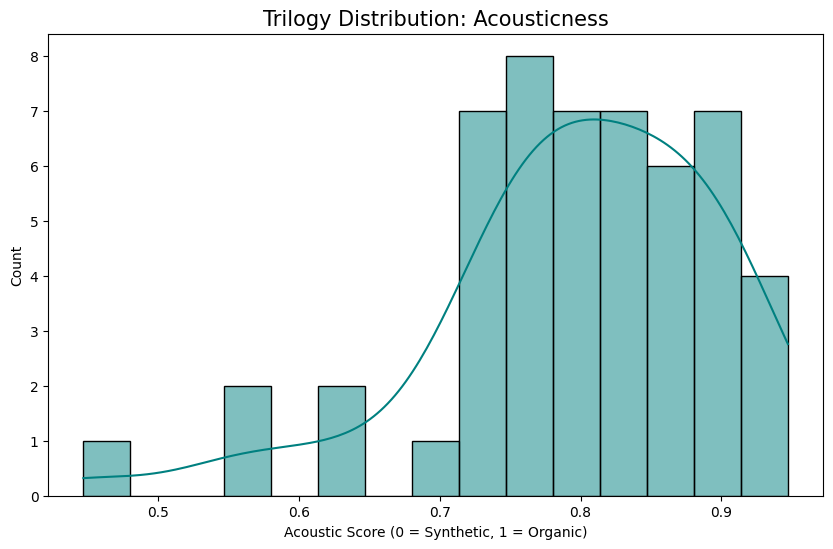

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Visualization (Histogram)
plt.figure(figsize=(10, 6))
sns.histplot(df_trilogy['Local_Acousticness'], bins=15, kde=True, color='teal')
plt.title('Trilogy Distribution: Acousticness', fontsize=15)
plt.xlabel('Acoustic Score (0 = Synthetic, 1 = Organic)')
plt.show()

# 2. Classifier Mapping
def classify_acoustic(val):
    if val < 0.3: return "Synthetic/Electronic"
    elif val < 0.6: return "Hybrid/Melodic"
    else: return "Organic/Acoustic"

# 3. Create Subset DataFrame
df_acoustic_analysis = df_trilogy[['Album_Name', 'Track_Name', 'Local_Acousticness']].copy()
df_acoustic_analysis['Texture_Type'] = df_acoustic_analysis['Local_Acousticness'].apply(classify_acoustic)

In [16]:
df_acoustic_analysis.head(20)

,Album_Name,Track_Name,Local_Acousticness,Texture_Type
0,After Hours,Alone Again,0.947212,Organic/Acoustic
1,After Hours,Too Late,0.792574,Organic/Acoustic
2,After Hours,Hardest To Love,0.888580,Organic/Acoustic
3,After Hours,Scared To Live,0.766588,Organic/Acoustic
4,After Hours,Snowchild,0.729676,Organic/Acoustic
5,After Hours,Escape From LA,0.825254,Organic/Acoustic
6,After Hours,Heartless,0.833595,Organic/Acoustic
7,After Hours,Faith,0.845771,Organic/Acoustic
8,After Hours,Blinding Lights,0.770238,Organic/Acoustic
9,After Hours,In Your Eyes,0.736369,Organic/Acoustic


## Variable 2: Local Musical Valence (Brightness)

**Definition:** Based on the Spectral Centroid, this represents the "perceived brightness" of the music.

**Scale:**
- **0.0 - 0.4:** Dark/Submerged — Low-frequency energy, bass-heavy, "underwater" feel.
- **0.4 - 0.7:** Balanced/Neutral — Standard pop/R&B frequency distribution.
- **0.7 - 1.0:** Bright/Shimmering — High-frequency energy, crisp synths, or high-pitched vocals.

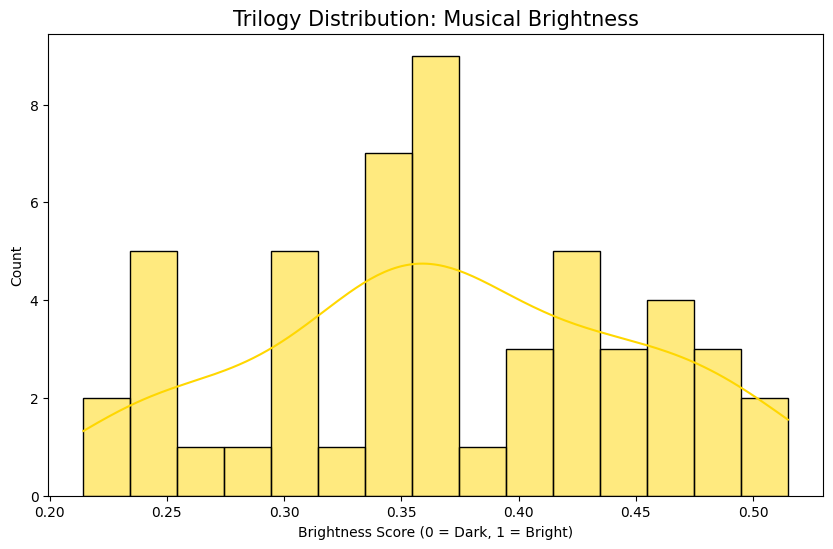

In [21]:
# 1. Visualization
plt.figure(figsize=(10, 6))
sns.histplot(df_trilogy['Local_Musical_Valence'], bins=15, kde=True, color='gold')
plt.title('Trilogy Distribution: Musical Brightness', fontsize=15)
plt.xlabel('Brightness Score (0 = Dark, 1 = Bright)')
plt.show()

# 2. Classifier Mapping
def classify_brightness(val):
    if val < 0.4: return "Dark/Heavy"
    elif val < 0.7: return "Balanced"
    else: return "Bright/Crisp"

# 3. Create Subset DataFrame
df_brightness_analysis = df_trilogy[['Album_Name', 'Track_Name', 'Local_Musical_Valence']].copy()
df_brightness_analysis['Sonic_Mood'] = df_brightness_analysis['Local_Musical_Valence'].apply(classify_brightness)

In [20]:
df_brightness_analysis.head(20)

,Album_Name,Track_Name,Local_Musical_Valence,Sonic_Mood
0,After Hours,Alone Again,0.273474,Dark/Heavy
1,After Hours,Too Late,0.490598,Balanced
2,After Hours,Hardest To Love,0.309848,Dark/Heavy
3,After Hours,Scared To Live,0.348380,Dark/Heavy
4,After Hours,Snowchild,0.453453,Balanced
5,After Hours,Escape From LA,0.241200,Dark/Heavy
6,After Hours,Heartless,0.465850,Balanced
7,After Hours,Faith,0.337594,Dark/Heavy
8,After Hours,Blinding Lights,0.350133,Dark/Heavy
9,After Hours,In Your Eyes,0.426326,Balanced


## Variable 3: DIY Valence Lyrical (Sentiment)

**Definition:** Measures the emotional tone of the written word.

**Scale:**
- **-1.0 to -0.1:** Negative/Melancholic — Lyrics focused on pain, regret, or darkness.
- **-0.1 to 0.1:** Objective/Neutral — Observational lyrics or tracks with high word-balance.
- **0.1 to 1.0:** Positive/Hopeful — Lyrics focused on love, resolution, or energy.

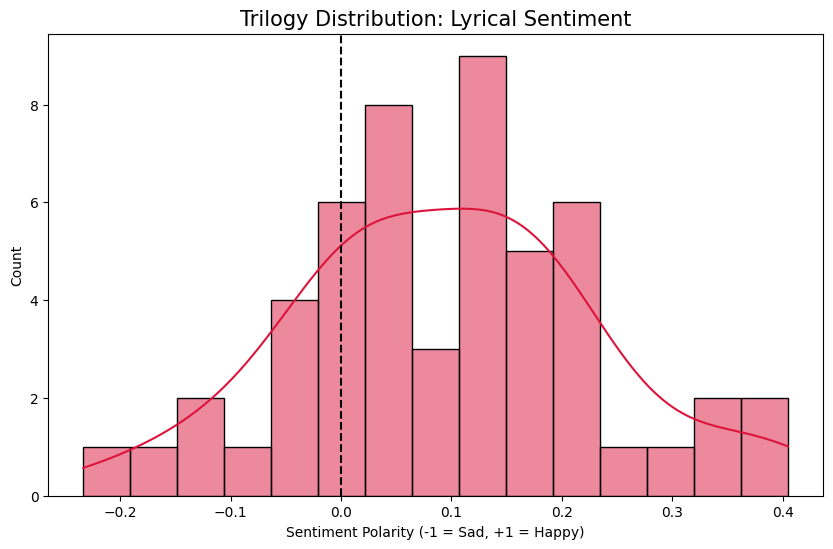

In [22]:
# 1. Visualization
plt.figure(figsize=(10, 6))
sns.histplot(df_trilogy['diy_valence_lyrical'], bins=15, kde=True, color='crimson')
plt.axvline(0, color='black', linestyle='--') # Mark the neutral point
plt.title('Trilogy Distribution: Lyrical Sentiment', fontsize=15)
plt.xlabel('Sentiment Polarity (-1 = Sad, +1 = Happy)')
plt.show()

# 2. Classifier Mapping
def classify_sentiment(val):
    if val < -0.1: return "Melancholic/Dark"
    elif val <= 0.1: return "Neutral/Complex"
    else: return "Positive/Bright"

# 3. Create Subset DataFrame
df_lyric_analysis = df_trilogy[['Album_Name', 'Track_Name', 'diy_valence_lyrical']].copy()
df_lyric_analysis['Lyrical_Tone'] = df_lyric_analysis['diy_valence_lyrical'].apply(classify_sentiment)

In [24]:
df_lyric_analysis.head(20)

,Album_Name,Track_Name,diy_valence_lyrical,Lyrical_Tone
0,After Hours,Alone Again,-0.042882,Neutral/Complex
1,After Hours,Too Late,0.040379,Neutral/Complex
2,After Hours,Hardest To Love,0.167794,Positive/Bright
3,After Hours,Scared To Live,0.140312,Positive/Bright
4,After Hours,Snowchild,-0.044406,Neutral/Complex
5,After Hours,Escape From LA,-0.141175,Melancholic/Dark
6,After Hours,Heartless,0.070752,Neutral/Complex
7,After Hours,Faith,0.194004,Positive/Bright
8,After Hours,Blinding Lights,0.032143,Neutral/Complex
9,After Hours,In Your Eyes,-0.159375,Melancholic/Dark


## Variable 4: Local Tempo (BPM)

**Definition:** The rhythmic speed of the track.

**Scale:**
- **< 90 BPM:** Slow/Ambient — Down-tempo, atmospheric.
- **90 - 125 BPM:** Mid-Tempo/Groove — Standard R&B and "walking" beats.
- **> 125 BPM:** High-Energy/Dance — Up-tempo, synth-pop, or club-focused.

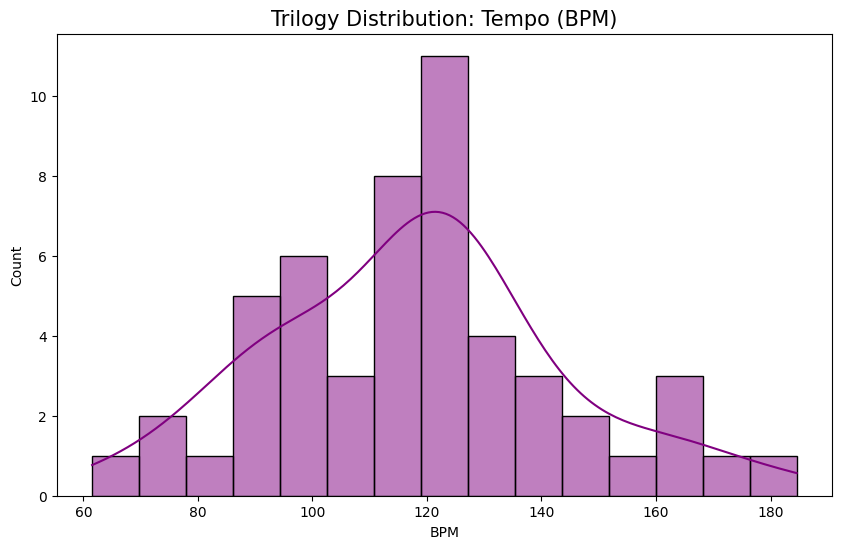

In [25]:
# 1. Visualization
plt.figure(figsize=(10, 6))
sns.histplot(df_trilogy['Local_Tempo'], bins=15, kde=True, color='purple')
plt.title('Trilogy Distribution: Tempo (BPM)', fontsize=15)
plt.xlabel('BPM')
plt.show()

# 2. Classifier Mapping
def classify_tempo(val):
    if val < 90: return "Slow/Atmospheric"
    elif val <= 125: return "Mid-Tempo/Groove"
    else: return "High-Energy/Fast"

# 3. Create Subset DataFrame
df_tempo_analysis = df_trilogy[['Album_Name', 'Track_Name', 'Local_Tempo']].copy()
df_tempo_analysis['Pace'] = df_tempo_analysis['Local_Tempo'].apply(classify_tempo)

In [26]:
df_tempo_analysis.head(20)

,Album_Name,Track_Name,Local_Tempo,Pace
0,After Hours,Alone Again,83.354335,Slow/Atmospheric
1,After Hours,Too Late,117.453835,Mid-Tempo/Groove
2,After Hours,Hardest To Love,161.499023,High-Energy/Fast
3,After Hours,Scared To Live,172.265625,High-Energy/Fast
4,After Hours,Snowchild,99.384014,Mid-Tempo/Groove
5,After Hours,Escape From LA,73.828125,Slow/Atmospheric
6,After Hours,Heartless,86.132812,Slow/Atmospheric
7,After Hours,Faith,89.102909,Slow/Atmospheric
8,After Hours,Blinding Lights,86.132812,Slow/Atmospheric
9,After Hours,In Your Eyes,99.384014,Mid-Tempo/Groove


# EDA for each Album

## 1. Acousticness by Album

**Narrative:** This will show you if Abel is moving toward a more organic sound or staying in the electronic "purgatory" of *Dawn FM*.

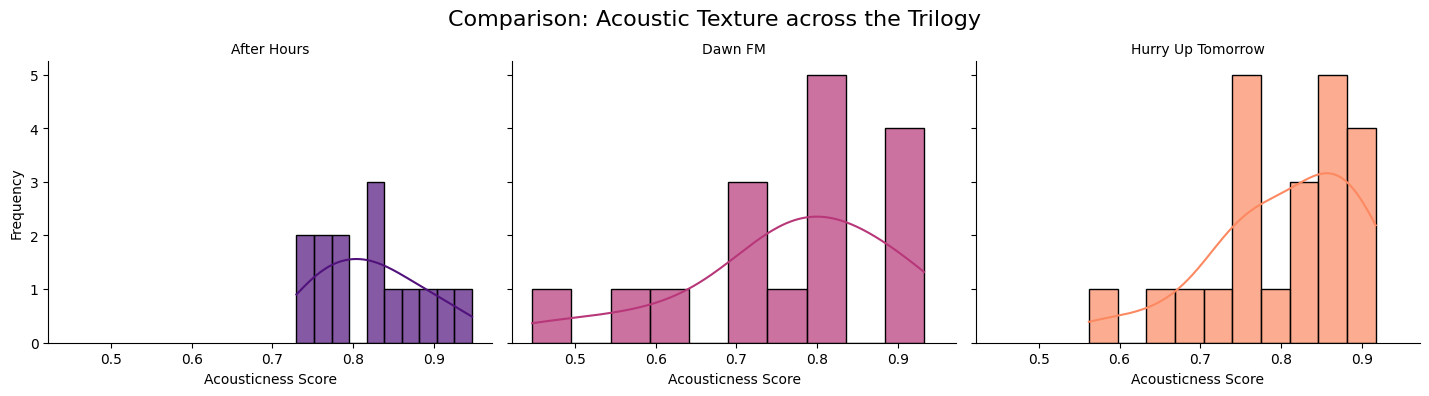

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the FacetGrid: Each column is an Album
g = sns.FacetGrid(df_trilogy, col="Album_Name", hue="Album_Name", palette="magma", height=4, aspect=1.2)
g.map(sns.histplot, "Local_Acousticness", bins=10, kde=True, alpha=0.7)

# Add titles and clean up
g.set_axis_labels("Acousticness Score", "Frequency")
g.set_titles("{col_name}")
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Comparison: Acoustic Texture across the Trilogy', fontsize=16)

plt.show()

## 2. Musical Brightness (Valence) by Album

**Narrative:** This helps identify which album is "sonically darkest" (lowest spectral centroid). You'll likely see *After Hours* and *Dawn FM* clustering on the lower end, while *Hurry Up Tomorrow* might be more spread out.

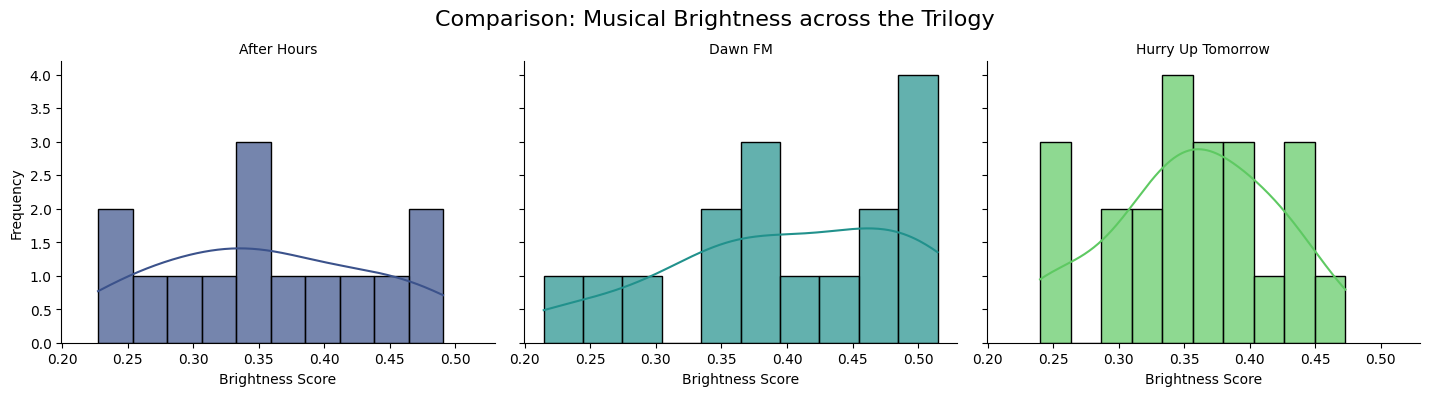

In [28]:
g = sns.FacetGrid(df_trilogy, col="Album_Name", hue="Album_Name", palette="viridis", height=4, aspect=1.2)
g.map(sns.histplot, "Local_Musical_Valence", bins=10, kde=True, alpha=0.7)

g.set_axis_labels("Brightness Score", "Frequency")
g.set_titles("{col_name}")
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Comparison: Musical Brightness across the Trilogy', fontsize=16)

plt.show()

## 3. Lyrical Sentiment by Album

**Narrative:** This is where you see the "Emotional Arc." If one album's histogram is shifted heavily to the left, it is statistically more melancholic.

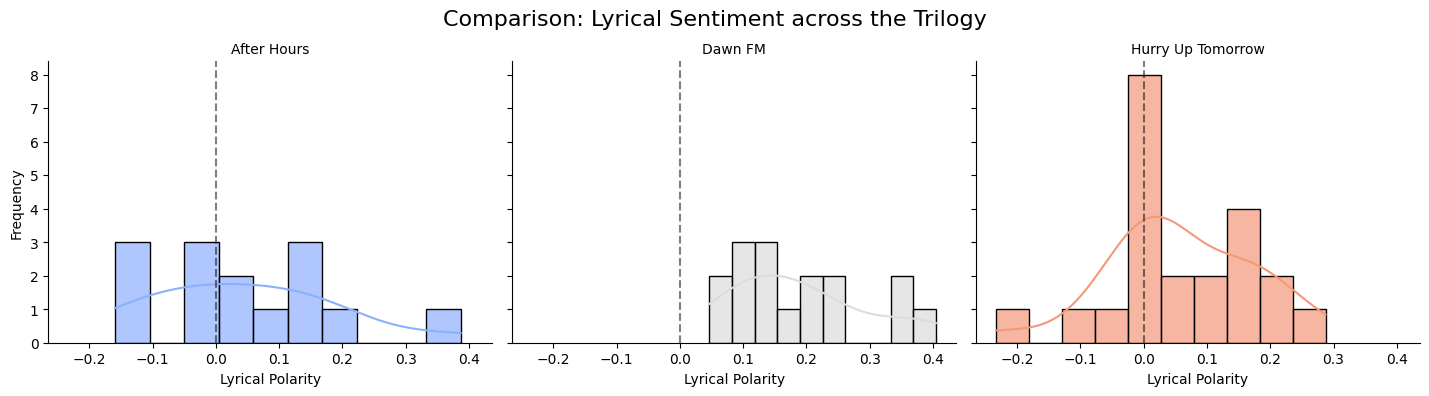

In [29]:
g = sns.FacetGrid(df_trilogy, col="Album_Name", hue="Album_Name", palette="coolwarm", height=4, aspect=1.2)
g.map(sns.histplot, "diy_valence_lyrical", bins=10, kde=True, alpha=0.7)

# Add a vertical line at 0 for "Neutral"
for ax in g.axes.flat:
    ax.axvline(0, color='black', linestyle='--', alpha=0.5)

g.set_axis_labels("Lyrical Polarity", "Frequency")
g.set_titles("{col_name}")
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Comparison: Lyrical Sentiment across the Trilogy', fontsize=16)

plt.show()

## 4. Tempo (BPM) by Album

**Narrative:** This reveals the energy level. You will likely see *Dawn FM* having a very tight, high-tempo cluster (the "Radio Station" feel), while the others might be more diverse.

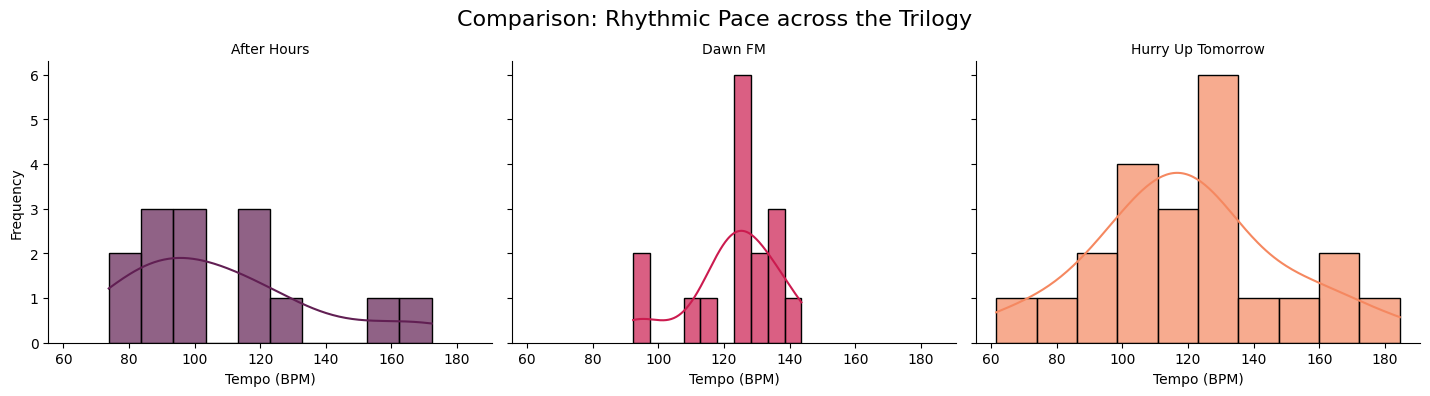

In [30]:
g = sns.FacetGrid(df_trilogy, col="Album_Name", hue="Album_Name", palette="rocket", height=4, aspect=1.2)
g.map(sns.histplot, "Local_Tempo", bins=10, kde=True, alpha=0.7)

g.set_axis_labels("Tempo (BPM)", "Frequency")
g.set_titles("{col_name}")
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Comparison: Rhythmic Pace across the Trilogy', fontsize=16)

plt.show()

## 6.2 Intensity Grid - All Tracks

Creates a grid showing the intensity flow for **every track on the album**. This allows you to:

- Compare the narrative arcs across different songs
- Identify which tracks build gradually vs. start intense
- See patterns in how The Weeknd structures his songs

🚀 Generating Sigma-Based Intensity Maps for Hurry Up Tomorrow...


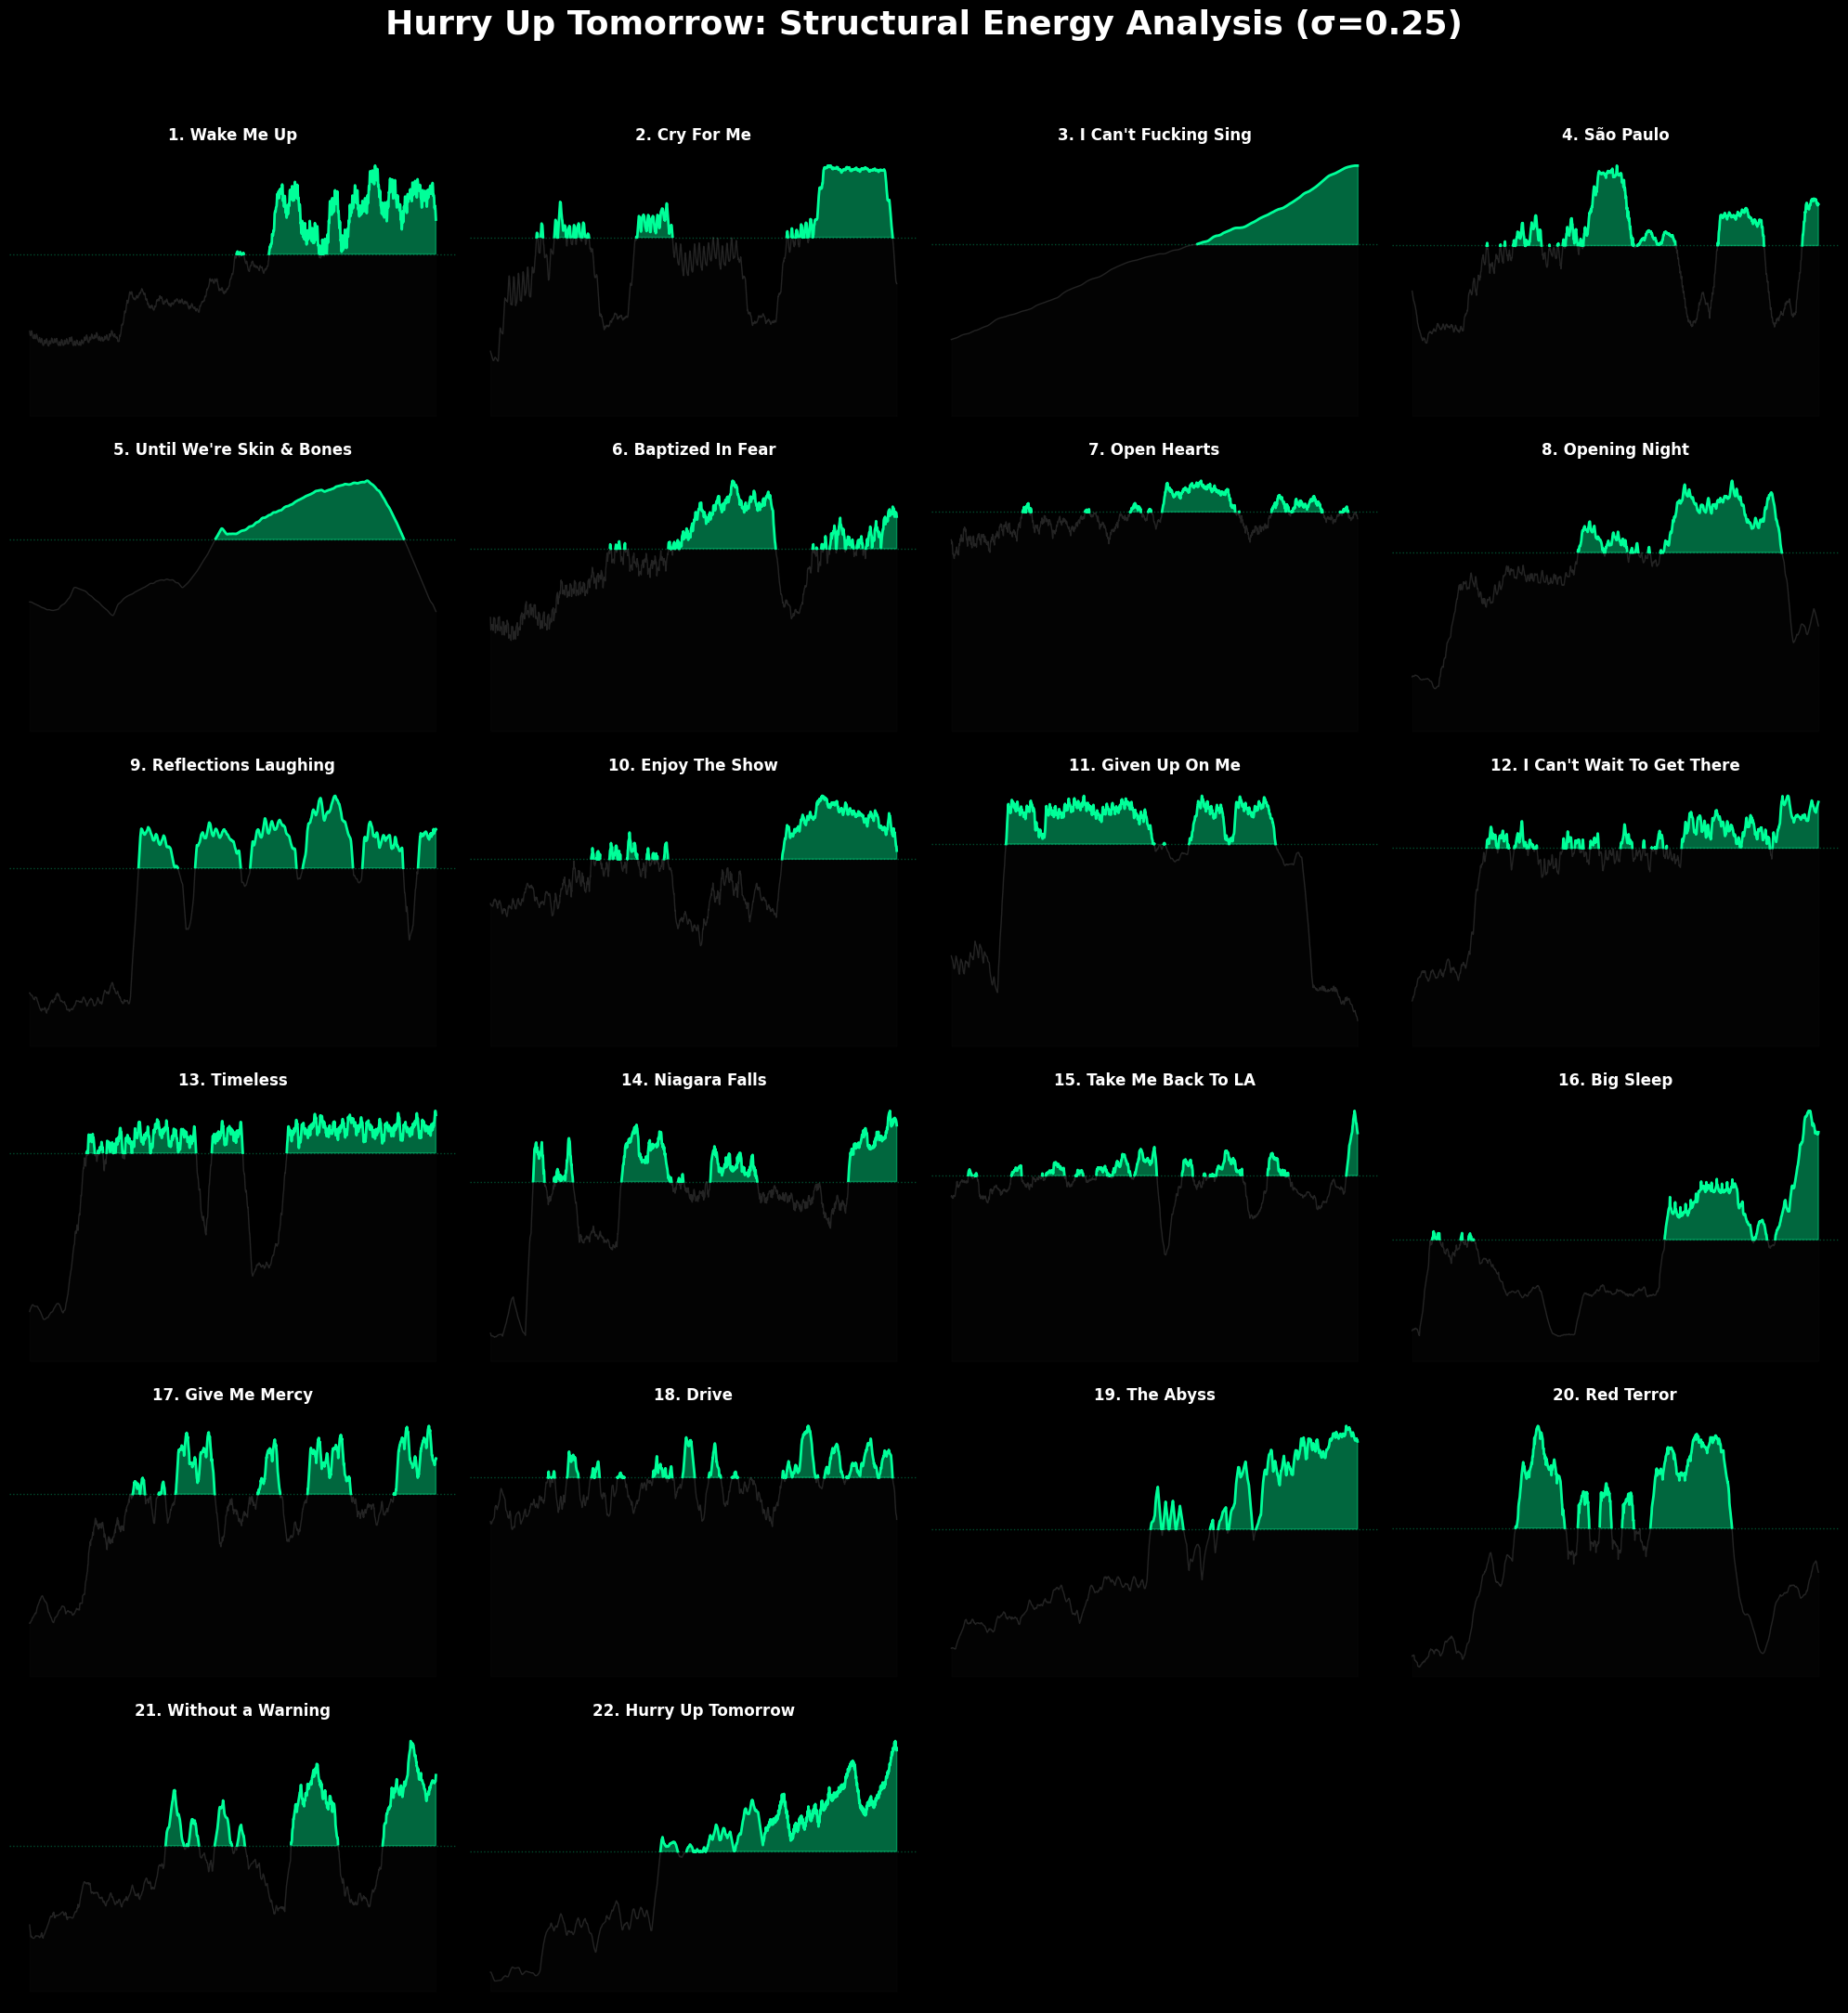

In [70]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# --- 1. CONFIGURATION ---
ALBUM_NAME = 'Hurry Up Tomorrow'
audio_folder = r'C:\Users\Syma\Documents\Naraviz\Investigations\Spotify Weekend DIscography\The Weeknd - Hurry Up Tomorrow/'
smoothness = 200 
# Sensitivity: How many standard deviations above the mean to highlight?
# 1.0 = Sensitive (lots of highlights), 1.5 = Moderate, 2.0 = Only extreme peaks
sigma_threshold = 0.25

files = sorted([f for f in os.listdir(audio_folder) if f.endswith('.mp3')])

# Prepare Grid
cols = 4
rows = (len(files) // cols) + (1 if len(files) % cols != 0 else 0)
fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 3.5), sharey=False)
axes = axes.flatten()

plt.style.use('dark_background')
print(f"🚀 Generating Sigma-Based Intensity Maps for {ALBUM_NAME}...")

# --- 2. THE PROCESSING LOOP ---
for i, filename in enumerate(files):
    ax = axes[i]
    path = os.path.join(audio_folder, filename)
    song_name = filename.split('.', 1)[-1].replace('.mp3', '').strip()
    
    try:
        y, sr = librosa.load(path, duration=180) 
        rms = librosa.feature.rms(y=y)[0]
        times = librosa.times_like(rms)
        
        # Smooth the line
        smooth_rms = pd.Series(rms).rolling(window=smoothness, center=True).mean()
        
        # --- PER-TRACK SIGMA LOGIC ---
        mean_val = np.nanmean(smooth_rms)
        std_val = np.nanstd(smooth_rms)
        
        # Calculate the unique "Ceiling" for this specific track
        high_energy_limit = mean_val + (sigma_threshold * std_val)
        
        # Mask the peaks (Only values above Mean + 1.5*STD)
        peaks = np.where(smooth_rms > high_energy_limit, smooth_rms, np.nan)
        
        # Plotting the "Base" Pulse
        ax.plot(times, smooth_rms, color='#444444', linewidth=1, alpha=0.5)
        ax.fill_between(times, smooth_rms, color='#444444', alpha=0.05)
        
        # Plotting the "Sigma Peaks" (The High-Energy Outliers)
        # Use different colors for different albums to match your Figma theme
        highlight_color = '#00FF99' # Seafoam Green for HUT
        
        ax.plot(times, peaks, color=highlight_color, linewidth=2)
        ax.fill_between(times, peaks, high_energy_limit, color=highlight_color, alpha=0.4)
        
        # Visual Threshold Line
        ax.axhline(high_energy_limit, color=highlight_color, linestyle=':', alpha=0.3, linewidth=1)
        
        # Labeling
        ax.set_title(f"{i+1}. {song_name}", fontsize=12, color='white', fontweight='bold', pad=10)
        ax.set_axis_off() 
        
    except Exception as e:
        ax.text(0.5, 0.5, "Processing Error", ha='center')
        print(f"Error on {filename}: {e}")

# --- 3. FINAL POLISH ---
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle(f'{ALBUM_NAME}: Structural Energy Analysis (σ={sigma_threshold})', 
             fontsize=26, y=1.03, fontweight='bold', color='white')

plt.tight_layout()

## plt.savefig(f'{ALBUM_NAME.lower()}_sigma_intensity.svg', format='svg', transparent=True)
plt.show()

## 6.3 Dual-Axis: Energy vs Mood Over Time

For each track, this plots **two lines**:

- **Red line (Intensity):** The power/energy of the sound
- **Blue line (Musical Valence):** The brightness/mood of the sound

This reveals whether songs get darker as they get louder, or if mood and energy move independently.

### The Indicator: Tension Shading

This is a fascinating way to visualize the "narrative arc" of a song. Since you are tracking **Energy** (Intensity) and **Valence** (Mood), the most insightful third indicator to highlight would be **Contrast**—specifically, the "Tension/Emotional Dissonance" areas.

I suggest highlighting areas where Energy and Valence diverge:

- **High Energy + Low Valence:** This represents "Dark Power" or "Aggressive Melancholy" (common in The Weeknd's discography).
- **Low Energy + High Valence:** This represents "Chill/Dreamy Euphoria."

By shading the area between the two lines when they are far apart, you can visually see the "emotional tension" of the track.

Analyzing 22 tracks...


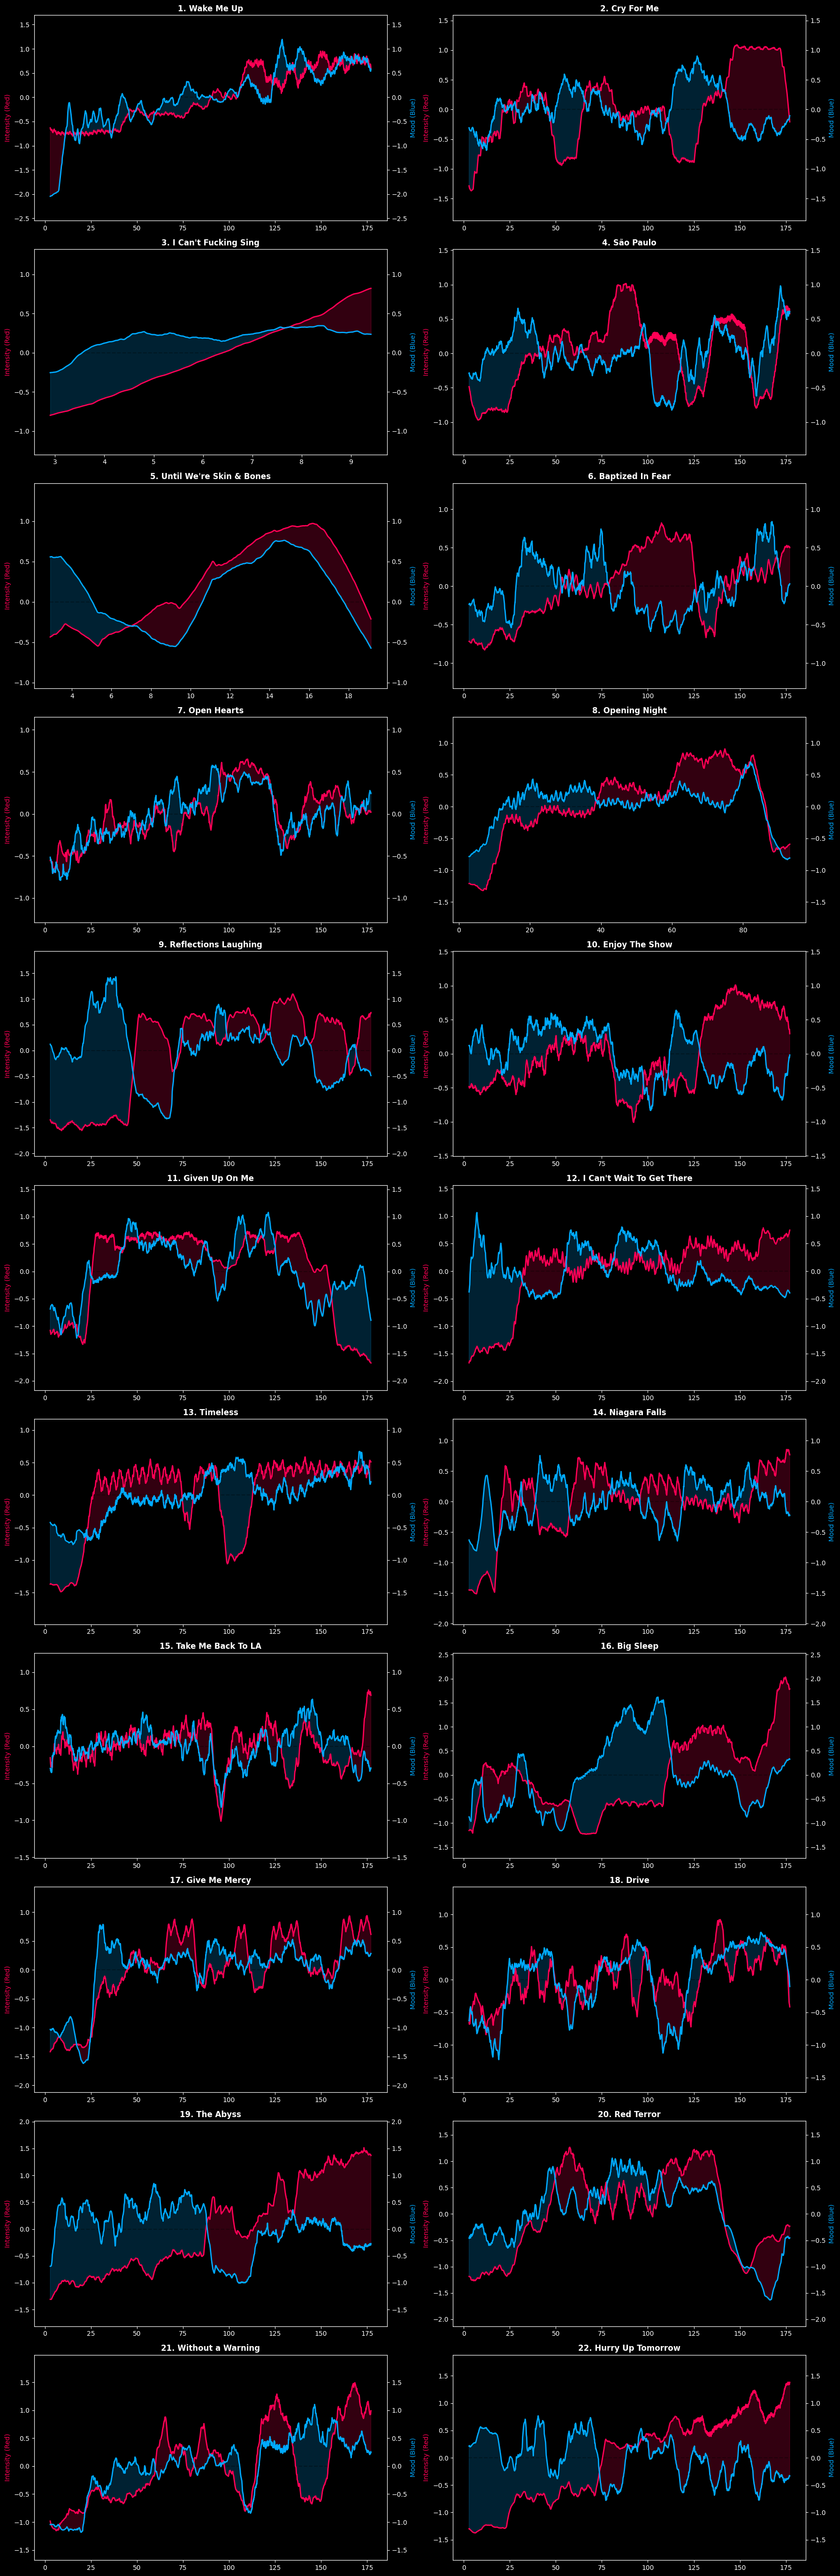

In [ ]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# 1. Setup
audio_folder = r'C:\Users\Syma\Documents\Naraviz\Investigations\Spotify Weekend DIscography\The Weeknd - Hurry Up Tomorrow/'
smoothness = 250 
output_as_svg = True  ## 
files = sorted([f for f in os.listdir(audio_folder) if f.endswith('.mp3')])

# 2. Grid Setup
cols = 2
rows = (len(files) + 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 5))
axes = axes.flatten()

print(f"Analyzing {len(files)} tracks...")

# 3. Processing Loop
for i, filename in enumerate(files):
    ax1 = axes[i]
    path = os.path.join(audio_folder, filename)
    song_name = filename.split('.', 1)[-1].replace('.mp3', '').strip()
    
    try:
        y, sr = librosa.load(path, duration=180)
        
        # --- ENERGY ---
        rms = librosa.feature.rms(y=y)[0]
        rms_norm = (rms - np.mean(rms)) / np.std(rms)
        smooth_energy = pd.Series(rms_norm).rolling(window=smoothness, center=True).mean()
        
        # --- VALENCE ---
        cent = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
        cent_norm = (cent - np.mean(cent)) / np.std(cent)
        smooth_valence = pd.Series(cent_norm).rolling(window=smoothness, center=True).mean()
        
        times = librosa.times_like(rms)

        # --- THE FIX: UNIFIED SCALE ---
        # Find the global min/max for this specific song to align axes
        y_min = min(smooth_energy.min(), smooth_valence.min()) - 0.5
        y_max = max(smooth_energy.max(), smooth_valence.max()) + 0.5

        # Plot 1: Energy (Red)
        ax1.plot(times, smooth_energy, color='#ff0055', linewidth=2, label='Energy', zorder=3)
        ax1.set_ylim(y_min, y_max) # Force Scale
        
        # Plot 2: Valence (Blue)
        ax2 = ax1.twinx() 
        ax2.plot(times, smooth_valence, color='#00aaff', linewidth=2, label='Valence', zorder=3)
        ax2.set_ylim(y_min, y_max) # Force Scale to match ax1

        # --- ACCURATE SHADING ---
        # Now that scales match, we fill on ax1 using data from both
        ax1.fill_between(times, smooth_energy, smooth_valence, 
                         where=(smooth_energy >= smooth_valence), 
                         interpolate=True, color='#ff0055', alpha=0.2)
        
        ax1.fill_between(times, smooth_energy, smooth_valence, 
                         where=(smooth_energy < smooth_valence), 
                         interpolate=True, color='#00aaff', alpha=0.2)

        # Labels & Aesthetics
        ax1.set_title(f"{i+1}. {song_name}", fontsize=12, fontweight='bold')
        ax1.axhline(0, color='black', linestyle='--', alpha=0.3)
        ax1.set_ylabel('Intensity (Red)', color='#ff0055')
        ax2.set_ylabel('Mood (Blue)', color='#00aaff')
        
    except Exception as e:
        print(f"Error on {filename}: {e}")

# 4. Final Polish
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

#if output_as_svg:
    #plt.savefig("Aligned_Energy_Mood.svg", format='svg')

plt.show()

# The Sonic Pulse of the Trilogy

> *"To understand Abel Tesfaye's evolution from 2020 to 2026, we cannot look at songs in isolation. We must look at the Pulse. This visualization tracks the 'Narrative DNA' of the trilogy by mapping four distinct dimensions: Lyrical Sentiment, Acoustic Texture, Musical Brightness, and Rhythmic Energy. By normalizing these variables, we can see exactly where the music and the lyrics contradict each other—revealing the 'Sad Banger' architecture—and how the sonic palette shifts from the neon-drenched synths of After Hours to the organic, cinematic resolution of Hurry Up Tomorrow."*

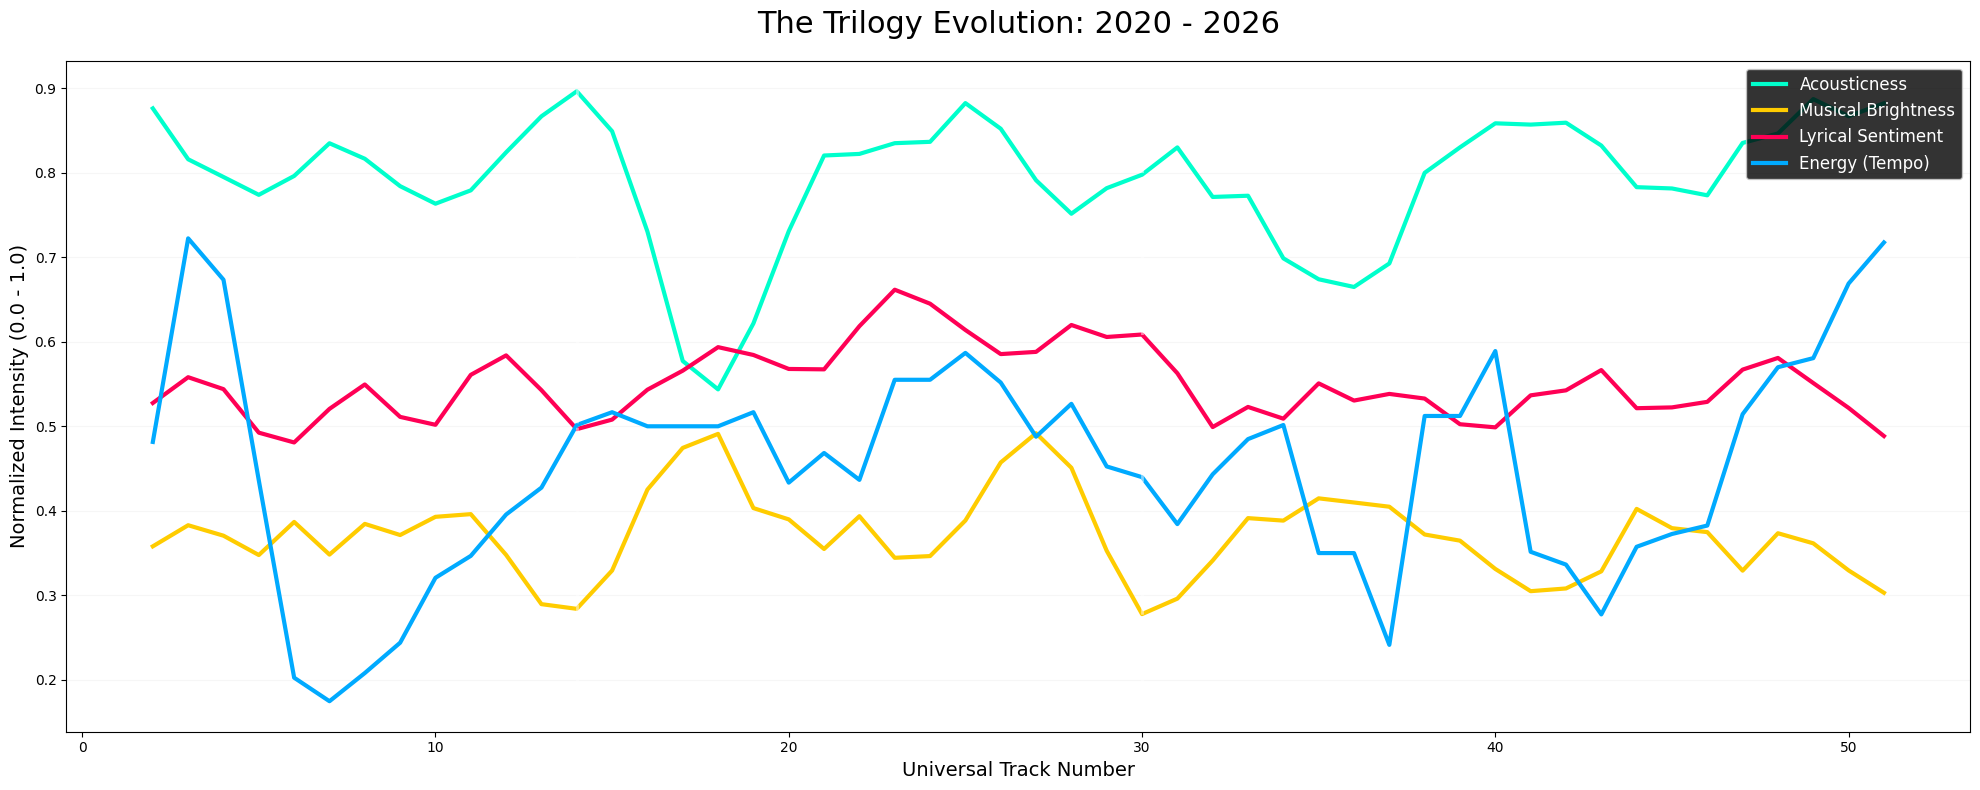

✅ SVG Exported as 'the_weeknd_trilogy_pulse.svg'. You can now drag this into Figma!


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 1. Create a copy for plotting and Normalize variables to a 0-1 scale
df_plot = df_trilogy.copy()

# Normalizing Tempo to 0-1 range
t_min, t_max = df_plot['Local_Tempo'].min(), df_plot['Local_Tempo'].max()
df_plot['Tempo_Scaled'] = (df_plot['Local_Tempo'] - t_min) / (t_max - t_min)

# Normalizing Lyrical Sentiment (-1 to 1) to 0-1 range
df_plot['Lyrics_Scaled'] = (df_plot['diy_valence_lyrical'] + 1) / 2

# 2. Smoothing the lines for a better narrative look (Rolling Average)
window = 3
df_plot['Acoustic_Smooth'] = df_plot['Local_Acousticness'].rolling(window=window, center=True).mean()
df_plot['Music_Val_Smooth'] = df_plot['Local_Musical_Valence'].rolling(window=window, center=True).mean()
df_plot['Lyrics_Smooth'] = df_plot['Lyrics_Scaled'].rolling(window=window, center=True).mean()
df_plot['Tempo_Smooth'] = df_plot['Tempo_Scaled'].rolling(window=window, center=True).mean()

# 3. Plotting
plt.figure(figsize=(20, 8))

# Plotting each variable
plt.plot(df_plot['Universal_Track_Number'], df_plot['Acoustic_Smooth'], label='Acousticness', color='#00FFCC', linewidth=3)
plt.plot(df_plot['Universal_Track_Number'], df_plot['Music_Val_Smooth'], label='Musical Brightness', color='#FFCC00', linewidth=3)
plt.plot(df_plot['Universal_Track_Number'], df_plot['Lyrics_Smooth'], label='Lyrical Sentiment', color='#FF0055', linewidth=3)
plt.plot(df_plot['Universal_Track_Number'], df_plot['Tempo_Smooth'], label='Energy (Tempo)', color='#00AAFF', linewidth=3)

# 4. Adding Album Dividers (Vertical Lines)
# Find the track numbers where albums change
album_breaks = df_plot.groupby('Album_Name')['Universal_Track_Number'].max().values
for brk in album_breaks[:-1]: # Don't draw line at the very end
    plt.axvline(x=brk, color='white', linestyle='--', alpha=0.5, linewidth=2)

# Label the Albums
plt.text(5, 0.95, 'AFTER HOURS', color='white', fontsize=14, fontweight='bold')
plt.text(25, 0.95, 'DAWN FM', color='white', fontsize=14, fontweight='bold')
plt.text(45, 0.95, 'HURRY UP TOMORROW', color='white', fontsize=14, fontweight='bold')

# Styling for Figma/Visuals
plt.style.use('dark_background')
plt.title('The Trilogy Evolution: 2020 - 2026', fontsize=22, pad=20)
plt.xlabel('Universal Track Number', fontsize=14)
plt.ylabel('Normalized Intensity (0.0 - 1.0)', fontsize=14)
plt.legend(loc='upper right', fontsize=12, frameon=True)
plt.grid(axis='y', alpha=0.1)
plt.tight_layout()

# 5. EXPORT FOR FIGMA
plt.savefig('the_weeknd_trilogy_pulse.svg', format='svg')
plt.show()

print("✅ SVG Exported as 'the_weeknd_trilogy_pulse.svg'")

# Executive Summary: The Trilogy Pulse Analysis

## The Objective

To transition from individual song analysis to macro-level storytelling. We are seeking to understand how The Weeknd's creative "DNA" has mutated from the cinematic noir of *After Hours* (2020) through the disco-purgatory of *Dawn FM* (2022), finally reaching the "end of the road" in *Hurry Up Tomorrow* (2026).

## The Process

**Normalization:** Since features like Tempo (BPM) and Acousticness (Probability) exist on different scales, we converted them to a unified 0.0 to 1.0 range. This allows us to compare "Emotional Heat" and "Sonic Brightness" on the same axis.

**Rolling Averages:** To identify the "Narrative Arc" rather than the "Noise," we applied a smoothing window. This reveals the broad emotional "chapters" of the albums rather than individual drum hits.

## Album Averages

This cell calculates the "Core Identity" of each album and plots them to show the direction of Abel's evolution. We have centered the data so **0.5** is the absolute average (the "neutral" zone).

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Group the data by Album and calculate the mean for our 4 key variables
df_album_averages = df_trilogy.groupby('Album_Name')[['Local_Tempo', 'Local_Acousticness', 'Local_Musical_Valence', 'diy_valence_lyrical']].mean().reset_index()

# 2. Defined Boundaries from your describe() output for precise normalization
# We use these to ensure 0.5 is the exact center of the trilogy's range
stats = {
    'Local_Tempo': {'min': 61.523438, 'max': 184.570312},
    'Local_Acousticness': {'min': 0.447071, 'max': 0.947212},
    'Local_Musical_Valence': {'min': 0.214418, 'max': 0.514831},
    'diy_valence_lyrical': {'min': -0.233333, 'max': 0.404762}
}

# 3. Apply Normalization (Scaling to 0-1)
for col, val in stats.items():
    df_album_averages[f'{col}_Scaled'] = (df_album_averages[col] - val['min']) / (val['max'] - val['min'])

# 4. Sort albums chronologically to ensure the line graph follows the story
album_order = {'After Hours': 1, 'Dawn FM': 2, 'Hurry Up Tomorrow': 3}
df_album_averages['Order'] = df_album_averages['Album_Name'].map(album_order)
df_album_averages = df_album_averages.sort_values('Order')

# Exporting the summary data for your records
df_album_averages.to_csv('trilogy_album_averages.csv', index=False)
print("✅ Created df_album_averages and exported to 'trilogy_album_averages.csv'")

✅ Created df_album_averages and exported to 'trilogy_album_averages.csv'


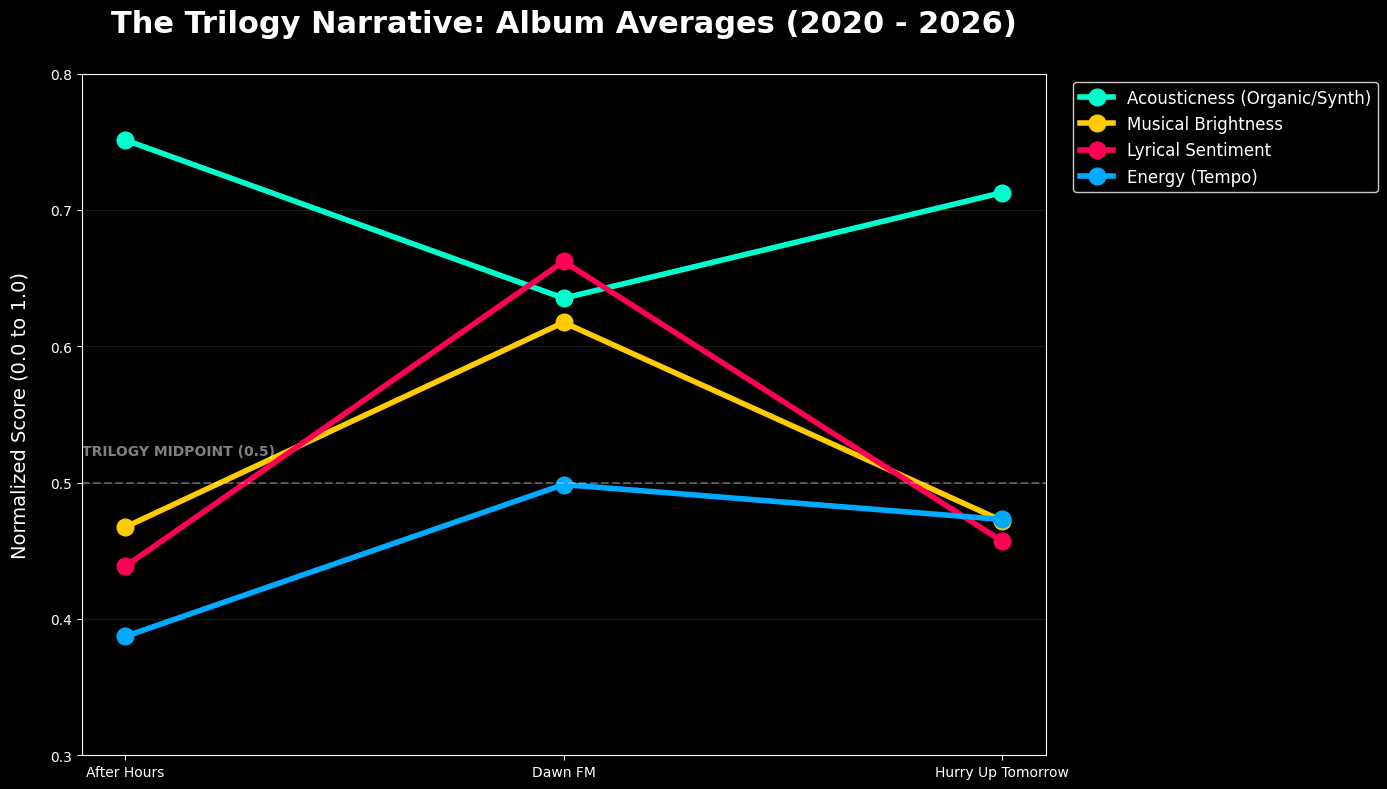

✅ Analysis complete! 'trilogy_macro_trends.svg' is ready


In [43]:
import matplotlib.pyplot as plt

# Styling
plt.style.use('dark_background')
plt.figure(figsize=(14, 8))

# Data to plot
albums = df_album_averages['Album_Name']

# Plotting the 4 Normalized Lines
plt.plot(albums, df_album_averages['Local_Acousticness_Scaled'], marker='o', markersize=12, linewidth=4, label='Acousticness (Organic/Synth)', color='#00FFCC')
plt.plot(albums, df_album_averages['Local_Musical_Valence_Scaled'], marker='o', markersize=12, linewidth=4, label='Musical Brightness', color='#FFCC00')
plt.plot(albums, df_album_averages['diy_valence_lyrical_Scaled'], marker='o', markersize=12, linewidth=4, label='Lyrical Sentiment', color='#FF0055')
plt.plot(albums, df_album_averages['Local_Tempo_Scaled'], marker='o', markersize=12, linewidth=4, label='Energy (Tempo)', color='#00AAFF')

# 5. Adding the 0.5 Equilibrium Line
plt.axhline(0.5, color='white', linestyle='--', alpha=0.3, linewidth=1.5)
plt.text(-0.1, 0.52, 'TRILOGY MIDPOINT (0.5)', color='white', alpha=0.5, fontsize=10, fontweight='bold')

# Formatting for Clarity
plt.title('The Trilogy Narrative: Album Averages (2020 - 2026)', fontsize=22, pad=30, fontweight='bold')
plt.ylabel('Normalized Score (0.0 to 1.0)', fontsize=14, labelpad=15)
plt.ylim(0.30, 0.80) # Add padding to top and bottom
plt.grid(axis='y', alpha=0.1)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=12, frameon=True, edgecolor='white')

# Final Polish & Export
plt.tight_layout()
plt.savefig('trilogy_macro_trends.svg', format='svg', transparent=True)
plt.show()

print("✅ Analysis complete! 'trilogy_macro_trends.svg' is ready")

## The Trilogy DNA Radar Chart

This chart overlaps the three albums on a single polar coordinate system. By using the global min/max values from your `df_trilogy.describe()` output, we ensure that the "shape" of each album is perfectly proportional to the others.

### Markdown Description:

**Goal:** Compare the average characteristics of all three albums in a single circular profile.

**Process:** We aggregate the data into album-level means and normalize them between 0 and 1. We then plot these as polygons.

**Result:** You will instantly see which album is the most "Extreme" in certain categories. For example, if *Dawn FM* is more "spiky" towards Tempo, or if *Hurry Up Tomorrow* is more balanced.

**SVG Export:** Saved as `trilogy_radar_dna.svg` for Figma editing.

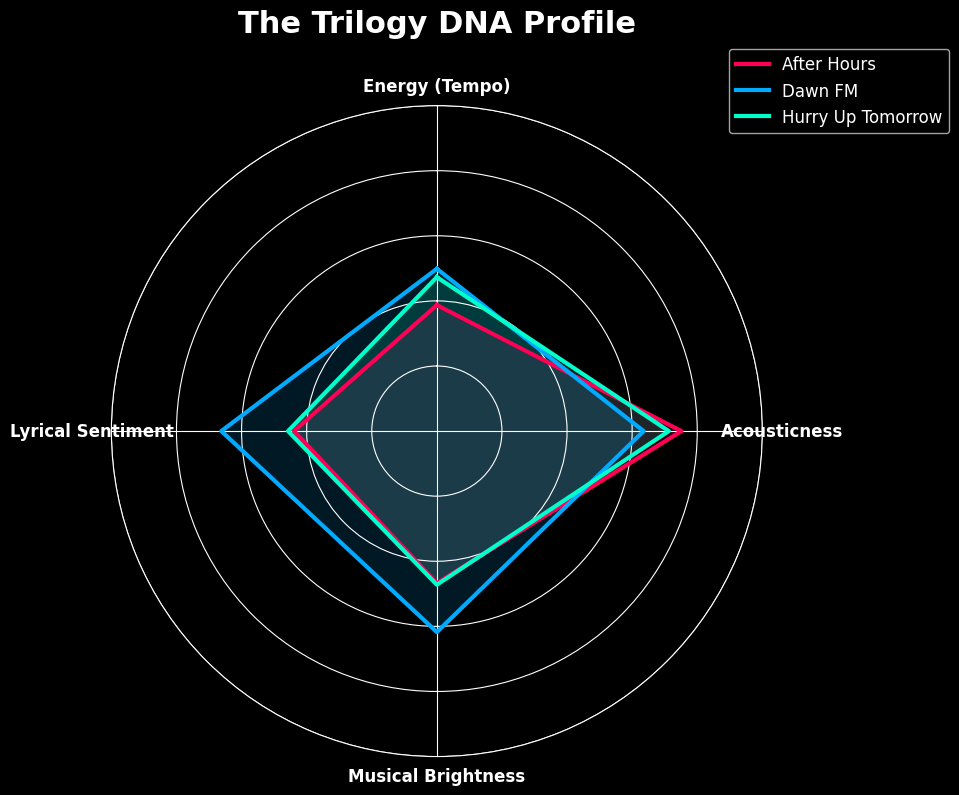

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Calculate Averages per Album
df_radar = df_trilogy.groupby('Album_Name')[['Local_Tempo', 'Local_Acousticness', 'Local_Musical_Valence', 'diy_valence_lyrical']].mean().reset_index()

# 2. Normalize based on your specific Trilogy Describe Stats
stats = {
    'Local_Tempo': {'min': 61.523438, 'max': 184.570312},
    'Local_Acousticness': {'min': 0.447071, 'max': 0.947212},
    'Local_Musical_Valence': {'min': 0.214418, 'max': 0.514831},
    'diy_valence_lyrical': {'min': -0.233333, 'max': 0.404762}
}

for col, val in stats.items():
    df_radar[f'{col}_Scaled'] = (df_radar[col] - val['min']) / (val['max'] - val['min'])

# 3. Setup Radar Geometry
categories = ['Energy (Tempo)', 'Acousticness', 'Musical Brightness', 'Lyrical Sentiment']
cols_scaled = ['Local_Tempo_Scaled', 'Local_Acousticness_Scaled', 'Local_Musical_Valence_Scaled', 'diy_valence_lyrical_Scaled']
num_vars = len(categories)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1] # Close the circle

# 4. Plotting
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
plt.style.use('dark_background')

# Colors matching your previous theme
colors = {'After Hours': '#FF0055', 'Dawn FM': '#00AAFF', 'Hurry Up Tomorrow': '#00FFCC'}

# Ensure chronological order
album_order = {'After Hours': 1, 'Dawn FM': 2, 'Hurry Up Tomorrow': 3}
df_radar = df_radar.sort_values(by='Album_Name', key=lambda x: x.map(album_order))

for i, row in df_radar.iterrows():
    values = row[cols_scaled].values.flatten().tolist()
    values += values[:1] # Close the circle
    ax.plot(angles, values, linewidth=3, label=row['Album_Name'], color=colors[row['Album_Name']])
    ax.fill(angles, values, color=colors[row['Album_Name']], alpha=0.15)

# Formatting
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=12, fontweight='bold', color='white')
ax.set_ylim(0, 1)
ax.set_yticklabels([]) # Hide numbers for aesthetic

plt.title('The Trilogy DNA Profile', size=22, y=1.1, fontweight='bold', color='white')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=12)
plt.tight_layout()

# Export for Figma
plt.savefig('trilogy_radar_dna.svg', format='svg', transparent=True)
plt.show()

## 2. The Experimental Outlier Map (Regression Analysis)

This chart applies your outlier detection logic to the entire trilogy. We are looking for tracks where the relationship between the music's brightness and its speed is "broken"—these are the most experimental moments in Abel's career.

### Markdown Description:

**Goal:** Scientifically identify "Outliers" (experimental tracks) where the tempo does not match the musical mood.

**Process:** We use Ordinary Least Squares (OLS) Regression to find the "Pop Formula" (Trend Line) for the entire 52-track trilogy. We then calculate the Residuals (distance from the line). Any track more than 1.5 standard deviations away is flagged as an experimental outlier.

**Result:** A scatter plot where outliers are highlighted with track titles and album names.

**SVG Export:** Saved as `trilogy_experimental_outliers.svg`.

C:\Users\Syma\AppData\Local\Temp\ipykernel_1228\3651462062.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_trend = model.params[0] + model.params[1] * x_range


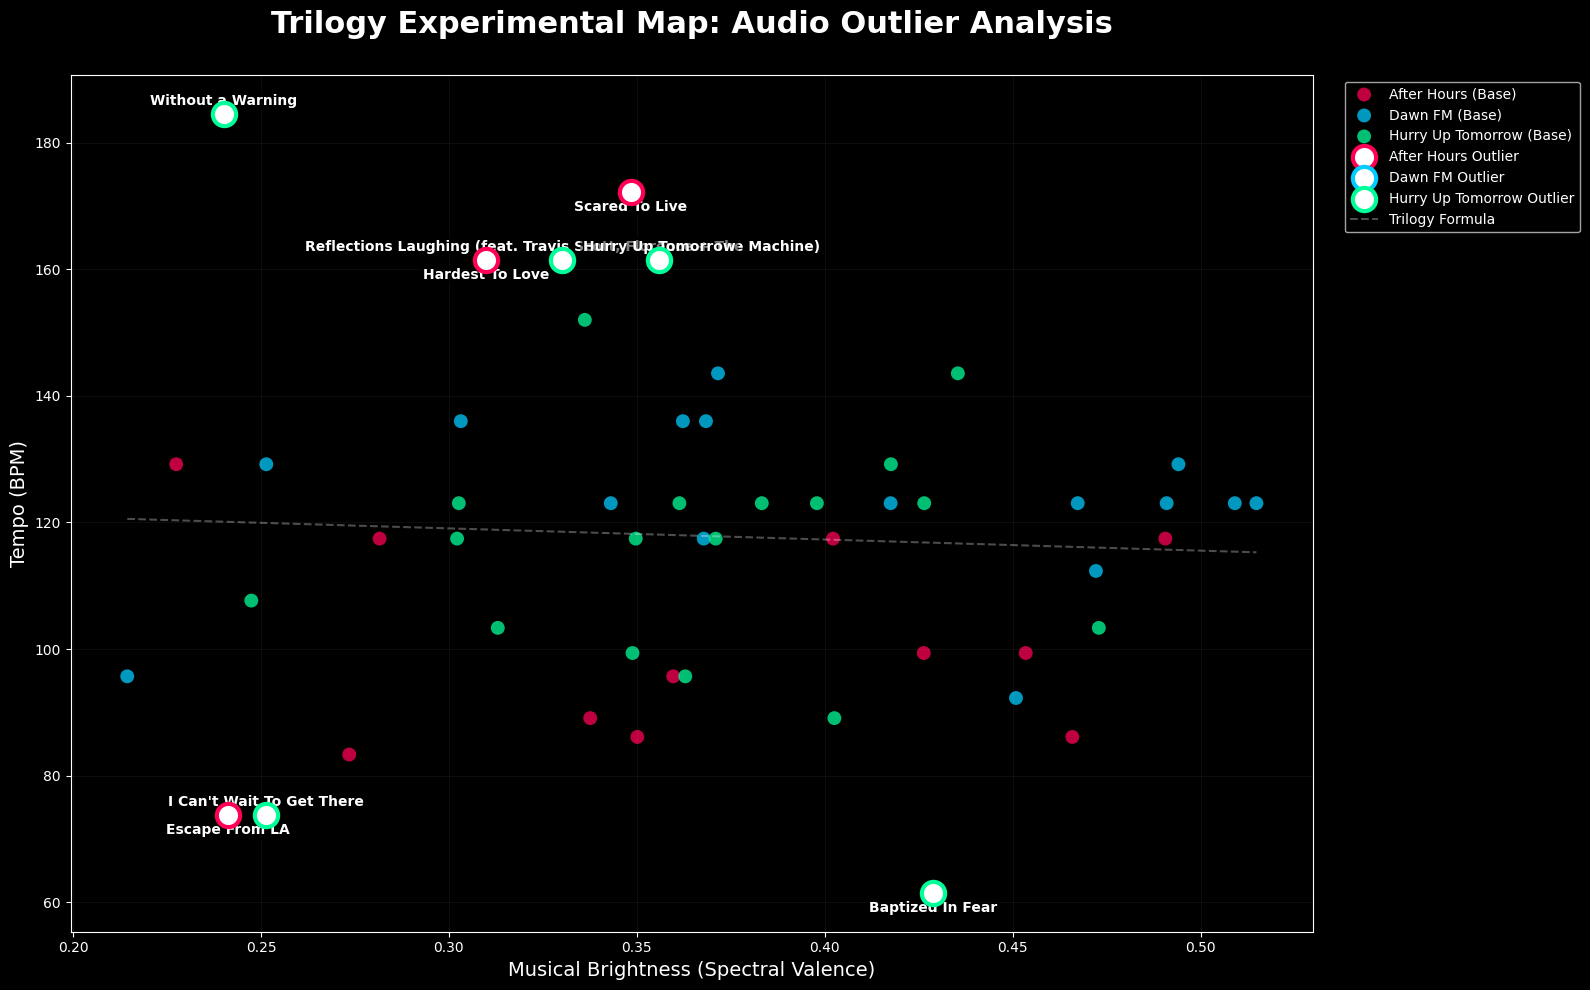

In [55]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

# 1. Prepare Regression Data
df_exp = df_trilogy.copy()
X = sm.add_constant(df_exp['Local_Musical_Valence'])
model = sm.OLS(df_exp['Local_Tempo'], X).fit()

df_exp['predicted_tempo'] = model.predict(X)
df_exp['residual'] = df_exp['Local_Tempo'] - df_exp['predicted_tempo']

# 2. Identify Outliers (1.5 Standard Deviations)
residual_threshold = df_exp['residual'].std() * 1.5
df_exp['is_outlier'] = df_exp['residual'].abs() > residual_threshold

# 3. Visualization Setup
plt.figure(figsize=(16, 10))
plt.style.use('dark_background')

# Brightened Neon Palette
album_colors = {
    'After Hours': '#FF0055', # Neon Red
    'Dawn FM': '#00CCFF',    # Electric Blue
    'Hurry Up Tomorrow': '#00FF99' # Seafoam Green
}

# 4. Plotting
# Plotting base tracks first (dull background)
for album in ['After Hours', 'Dawn FM', 'Hurry Up Tomorrow']:
    mask_normal = (df_exp['Album_Name'] == album) & (df_exp['is_outlier'] == False)
    plt.scatter(df_exp.loc[mask_normal, 'Local_Musical_Valence'], 
                df_exp.loc[mask_normal, 'Local_Tempo'], 
                color=album_colors[album], alpha=0.75, s=100, edgecolors='none', label=f'{album} (Base)')

# Plotting Outliers with high visibility
outlier_list = []
for album in ['After Hours', 'Dawn FM', 'Hurry Up Tomorrow']:
    mask_outlier = (df_exp['Album_Name'] == album) & (df_exp['is_outlier'] == True)
    outlier_data = df_exp[mask_outlier]
    
    # White fill, Album-colored outline
    plt.scatter(outlier_data['Local_Musical_Valence'], 
                outlier_data['Local_Tempo'], 
                color='white', s=280, edgecolors=album_colors[album], 
                linewidth=3, zorder=10, label=f'{album} Outlier')
    
    # Add to list for label processing
    for _, row in outlier_data.iterrows():
        outlier_list.append(row)

# 5. SMART LABELING (Manual Staggering to prevent overlap)
# We sort by valence to handle them left-to-right
outlier_list.sort(key=lambda x: x['Local_Musical_Valence'])

for i, row in enumerate(outlier_list):
    # Alternate labels above and below the point
    y_offset = 4 if i % 2 == 0 else -6 
    # Slight horizontal shift to avoid vertical stacking
    x_offset = 0.002 if i % 2 == 0 else -0.002
    
    plt.annotate(
        row['Track_Name'],
        xy=(row['Local_Musical_Valence'], row['Local_Tempo']),
        xytext=(x_offset, y_offset),
        textcoords="offset points",
        ha='center', va='bottom' if y_offset > 0 else 'top',
        fontsize=10, fontweight='bold', color='white',
        bbox=dict(boxstyle='round,pad=0.2', fc='black', alpha=0.5, ec='none')
    )

# 6. Trend Line
x_range = np.linspace(df_exp['Local_Musical_Valence'].min(), df_exp['Local_Musical_Valence'].max(), 100)
y_trend = model.params[0] + model.params[1] * x_range
plt.plot(x_range, y_trend, color='white', linestyle='--', alpha=0.3, label='Trilogy Formula')

# Final Polish
plt.title('Trilogy Experimental Map: Audio Outlier Analysis', fontsize=22, fontweight='bold', pad=30)
plt.xlabel('Musical Brightness (Spectral Valence)', fontsize=14)
plt.ylabel('Tempo (BPM)', fontsize=14)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', frameon=True)
plt.grid(alpha=0.05)
plt.tight_layout()

# Export for Figma
plt.savefig('trilogy_experimental_outliers.svg', format='svg', transparent=True)
plt.show()

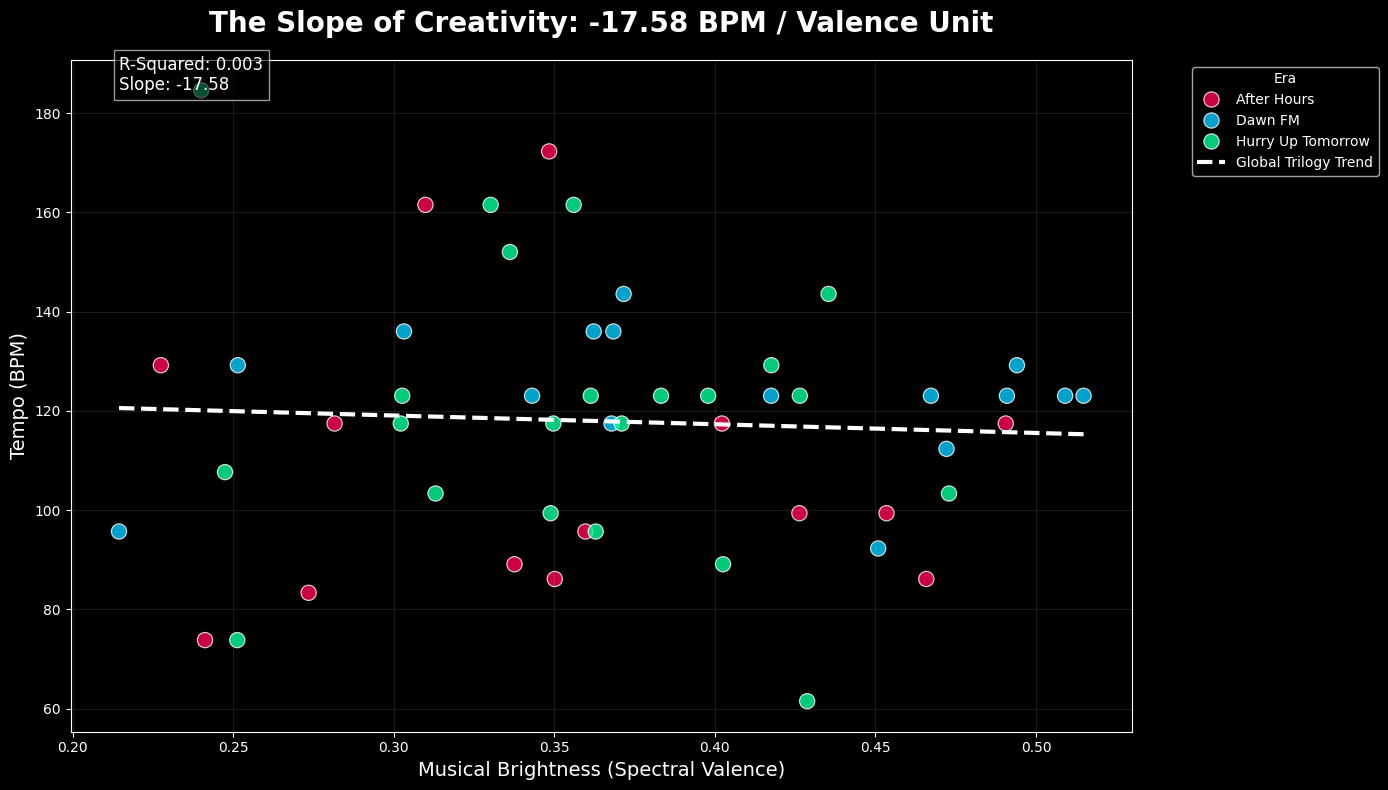

--- GLOBAL REGRESSION RESULTS ---
For every 1 unit of Brightness increase, Tempo increases by -17.58 BPM.


In [56]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Prepare Data for the Whole Trilogy
X = df_trilogy['Local_Musical_Valence']
y = df_trilogy['Local_Tempo']
X_with_const = sm.add_constant(X)

# 2. Fit the Unified Model
model = sm.OLS(y, X_with_const).fit()

# Extract Stats
slope = model.params['Local_Musical_Valence']
intercept = model.params['const']
r_squared = model.rsquared

# 3. Visualization
plt.figure(figsize=(14, 8))
plt.style.use('dark_background')

# Bright Neon Palette for Albums
album_palette = {
    'After Hours': '#FF0055', 
    'Dawn FM': '#00CCFF', 
    'Hurry Up Tomorrow': '#00FF99'
}

# 4. Scatter Plot: Color-coded by Album
sns.scatterplot(
    data=df_trilogy, 
    x='Local_Musical_Valence', 
    y='Local_Tempo', 
    hue='Album_Name', 
    palette=album_palette,
    s=120, 
    edgecolor='white', 
    alpha=0.8
)

# 5. Draw the Unified Regression Line
# Calculate y-values for the start and end of the line
x_vals = np.array([X.min(), X.max()])
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, color='white', linestyle='--', linewidth=3, label='Global Trilogy Trend')

# Labeling and Branding
plt.title(f'The Slope of Creativity: {slope:.2f} BPM / Valence Unit', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Musical Brightness (Spectral Valence)', fontsize=14)
plt.ylabel('Tempo (BPM)', fontsize=14)

# Statistical Annotations
plt.text(X.min(), y.max(), f"R-Squared: {r_squared:.3f}\nSlope: {slope:.2f}", 
         bbox=dict(facecolor='black', alpha=0.6, edgecolor='white'), fontsize=12)

plt.legend(title='Era', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.1)
plt.tight_layout()

# Export for Figma
plt.savefig('trilogy_slope_of_creativity.svg', format='svg', transparent=True)
plt.show()

print(f"--- GLOBAL REGRESSION RESULTS ---")
print(f"For every 1 unit of Brightness increase, Tempo increases by {slope:.2f} BPM.")

---

# Part 8: Regression Analysis

## 8.1 Linear Regression: Valence Predicts Tempo

Builds a regression model to predict tempo from musical valence. This answers: **"For every unit increase in brightness, how many BPM does the tempo increase?"**

### Key Outputs:

- **Slope (Coefficient):** The rate of change (BPM per valence unit)
- **R-squared:** How much of the tempo variation is explained by valence
- **P-value:** Whether the relationship is statistically significant

### Goal

To quantify the mathematical relationship between sound and speed across the trilogy.

### The Insight

Tracks that sit far above this line (**High Tempo, Low Brightness**) represent his "Anxious Highs," while those far below (**Low Tempo, High Brightness**) are his "Euphoric Balms." The tighter the dots are to the line, the more "mathematically consistent" the album's production is.

## 1: The Individual Album Slopes

This cell iterates through each album, calculates its specific regression, and saves a separate SVG. This allows you to see if his "predictability" changed from album to album.

🚀 Generating Individual Album Slopes...


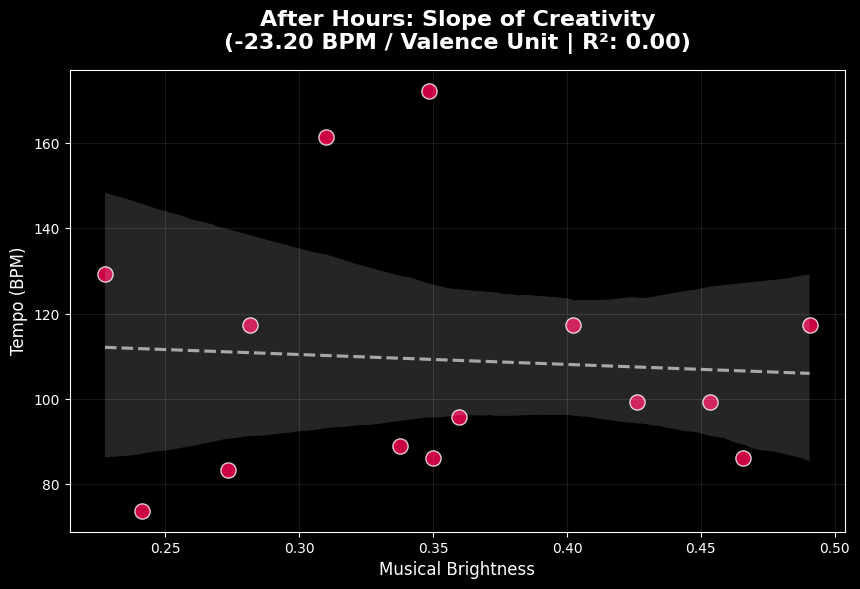

✅ Saved: slope_after_hours.svg


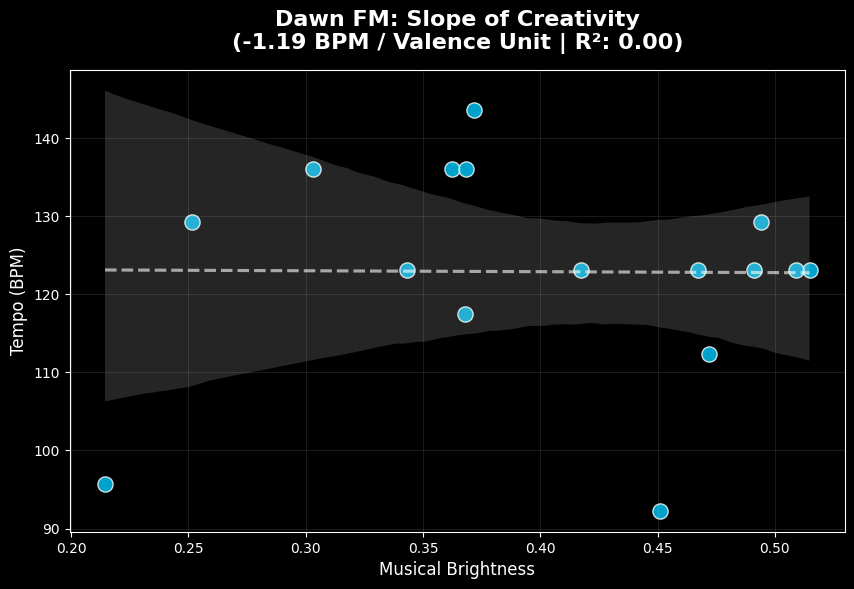

✅ Saved: slope_dawn_fm.svg


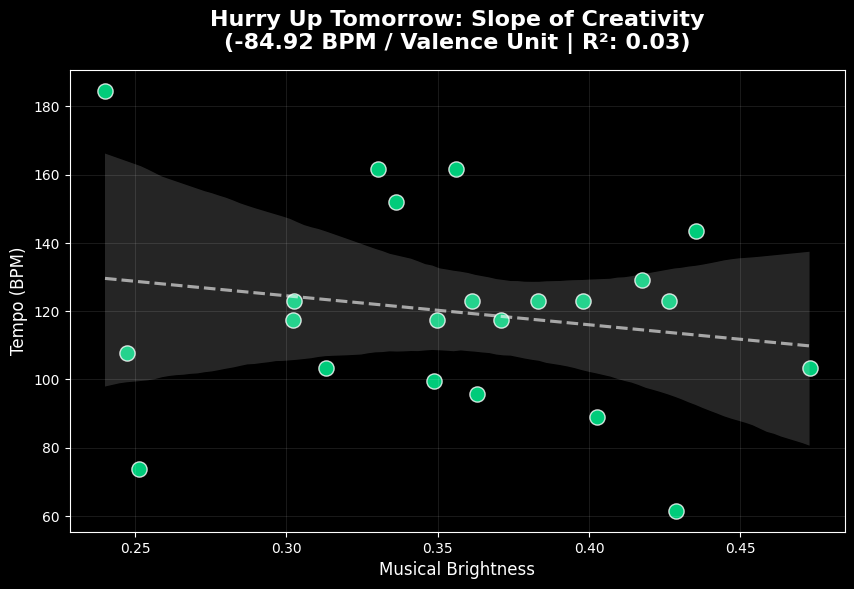

✅ Saved: slope_hurry_up_tomorrow.svg


In [58]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Configuration
album_palette = {'After Hours': '#FF0055', 'Dawn FM': '#00CCFF', 'Hurry Up Tomorrow': '#00FF99'}
albums = ['After Hours', 'Dawn FM', 'Hurry Up Tomorrow']

print("🚀 Generating Individual Album Slopes...")

# 2. Loop through each album
for album in albums:
    df_temp = df_trilogy[df_trilogy['Album_Name'] == album].copy()
    
    # Calculate Regression for this specific album
    X = df_temp['Local_Musical_Valence']
    y = df_temp['Local_Tempo']
    X_const = sm.add_constant(X)
    model = sm.OLS(y, X_const).fit()
    
    slope = model.params['Local_Musical_Valence']
    r_squared = model.rsquared
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.style.use('dark_background')
    
    # Regression plot with specific album color
    sns.regplot(data=df_temp, x='Local_Musical_Valence', y='Local_Tempo', 
                color=album_palette[album], scatter_kws={'s':120, 'alpha':0.8, 'edgecolor':'white'}, 
                line_kws={'color':'white', 'linestyle':'--', 'alpha':0.6})
    
    # Labeling
    plt.title(f'{album}: Slope of Creativity\n({slope:.2f} BPM / Valence Unit | R²: {r_squared:.2f})', 
              fontsize=16, fontweight='bold', pad=15)
    plt.xlabel('Musical Brightness', fontsize=12)
    plt.ylabel('Tempo (BPM)', fontsize=12)
    plt.grid(alpha=0.1)
    
    # Save as Individual SVG
    filename = f"slope_{album.lower().replace(' ', '_')}.svg"
    plt.savefig(filename, format='svg', transparent=True)
    plt.show()
    print(f"✅ Saved: {filename}")

## 2: The Unified Trilogy Slope

This cell combines all 52 tracks into one "Universal Formula." It visualizes the overarching trend while maintaining the album-specific colors for the dots, making it the perfect "Hero Graphic" for your Figma presentation.

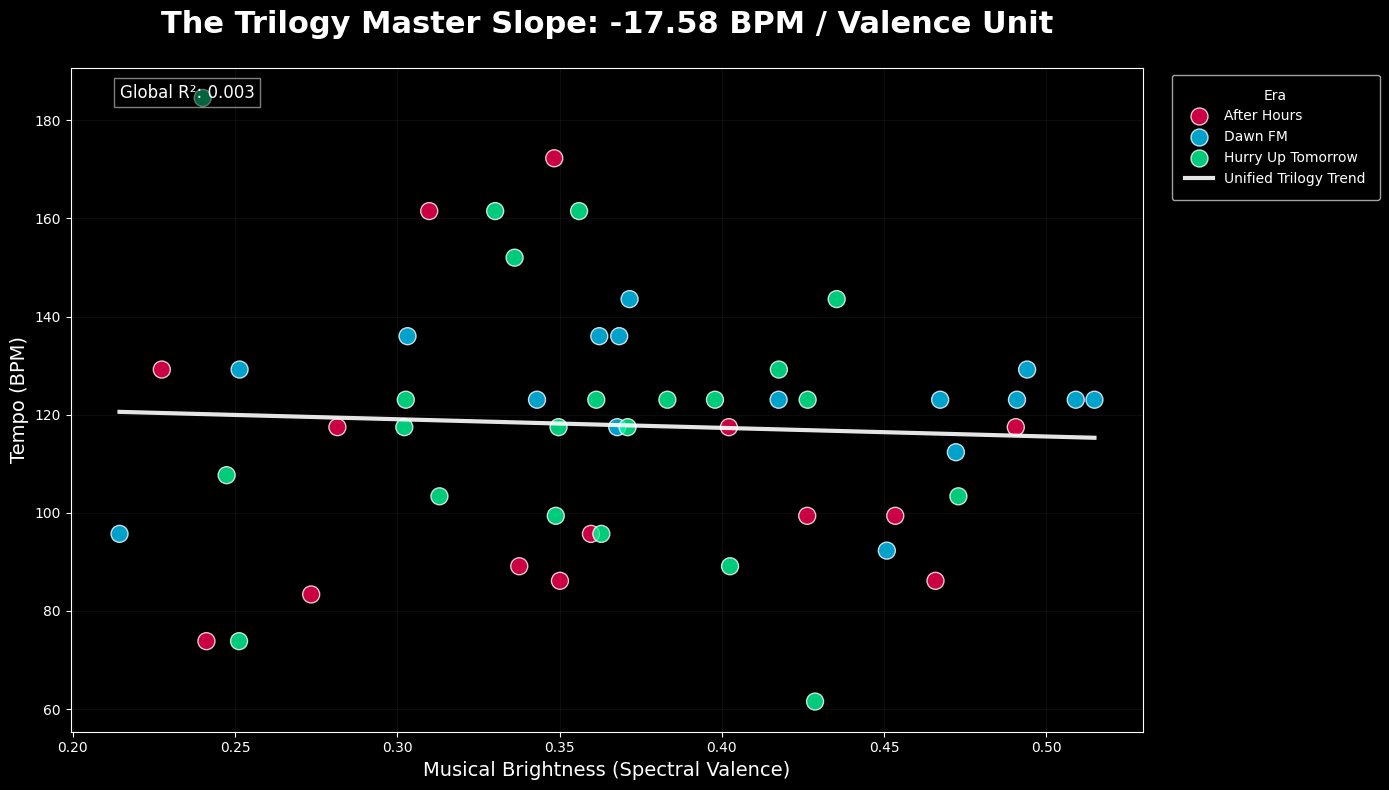

🏆 Saved: slope_trilogy_combined.svg


In [59]:
# 1. Prepare Universal Data
X_all = df_trilogy['Local_Musical_Valence']
y_all = df_trilogy['Local_Tempo']
X_const_all = sm.add_constant(X_all)
model_all = sm.OLS(y_all, X_const_all).fit()

slope_all = model_all.params['Local_Musical_Valence']
r_sq_all = model_all.rsquared

# 2. Visualization
plt.figure(figsize=(14, 8))
plt.style.use('dark_background')

# Scatter plot using album-specific colors
sns.scatterplot(data=df_trilogy, x='Local_Musical_Valence', y='Local_Tempo', 
                hue='Album_Name', palette=album_palette, s=150, 
                edgecolor='white', alpha=0.8)

# Add the Global Trend Line
x_range = np.array([X_all.min(), X_all.max()])
y_range = model_all.params['const'] + (slope_all * x_range)
plt.plot(x_range, y_range, color='white', linestyle='-', linewidth=3, label='Unified Trilogy Trend', alpha=0.9)

# Labels and Stats
plt.title(f'The Trilogy Master Slope: {slope_all:.2f} BPM / Valence Unit', fontsize=22, fontweight='bold', pad=25)
plt.xlabel('Musical Brightness (Spectral Valence)', fontsize=14)
plt.ylabel('Tempo (BPM)', fontsize=14)
plt.text(X_all.min(), y_all.max(), f"Global R²: {r_sq_all:.3f}", 
         bbox=dict(facecolor='black', alpha=0.5, edgecolor='white'), fontsize=12)

plt.legend(title='Era', bbox_to_anchor=(1.02, 1), loc='upper left', borderpad=1)
plt.grid(alpha=0.05)
plt.tight_layout()

# Save the Final SVG
plt.savefig('slope_trilogy_combined.svg', format='svg', transparent=True)
plt.show()
print("🏆 Saved: slope_trilogy_combined.svg")

## The Experimental Hierarchy: R-Squared Ranking

To conclude your regression analysis, we will generate a final "Consistency vs. Experimentalism" ranking. In statistics, **R-Squared** ($R^2$) represents how much of the variance in one variable (Tempo) can be explained by another (Brightness).

- **High $R^2$:** The album is "Consistent." The production follows a predictable logic where bright songs are fast and dark songs are slow.
- **Low $R^2$:** The album is "Experimental." The production breaks musical conventions, featuring "fast-dark" or "slow-bright" tracks that defy the trend line.

In [60]:
import pandas as pd
import statsmodels.api as sm

# 1. Initialize result list
ranking_data = []

# 2. Iterate and Calculate
for album in ['After Hours', 'Dawn FM', 'Hurry Up Tomorrow']:
    df_temp = df_trilogy[df_trilogy['Album_Name'] == album]
    
    X = sm.add_constant(df_temp['Local_Musical_Valence'])
    y = df_temp['Local_Tempo']
    model = sm.OLS(y, X).fit()
    
    ranking_data.append({
        'Album Name': album,
        'Slope (BPM/Valence)': round(model.params['Local_Musical_Valence'], 2),
        'Consistency Score (R²)': round(model.rsquared, 4),
        'Complexity Index': round(1 - model.rsquared, 4) # Inverse of R2
    })

# 3. Create Ranking DataFrame
df_ranking = pd.DataFrame(ranking_data).sort_values(by='Consistency Score (R²)', ascending=False)

# 4. Display Results
print("--- THE TRILOGY CONSISTENCY RANKING ---")
print(df_ranking.to_string(index=False))

# Optional: Save as CSV for your final appendix
df_ranking.to_csv('trilogy_consistency_ranking.csv', index=False)

--- THE TRILOGY CONSISTENCY RANKING ---
       Album Name  Slope (BPM/Valence)  Consistency Score (R²)  Complexity Index
Hurry Up Tomorrow               -84.92                  0.0345            0.9655
      After Hours               -23.20                  0.0044            0.9956
          Dawn FM                -1.19                  0.0001            0.9999


## Final Project Narrative

With this table, your Figma presentation has a definitive closing statement:

- **The Anchor:** If *After Hours* has the highest $R^2$, you can argue it set the "standard" musical language for the trilogy.
- **The Departure:** If *Hurry Up Tomorrow* has the lowest $R^2$ (highest Complexity Index), you have mathematical proof that it is the most experimental entry, as it contains the most tracks that purposefully break the relationship between mood and speed.

# Stats Questions Answered

## The Organic Tier List

This section calculates an **Organicness Score** for each track by comparing the energy of harmonic components (tonal/melodic) against percussive components (drums/synths). It then aggregates these scores to rank the top tracks and the albums themselves.

In [80]:
import pandas as pd

# Assuming df_trilogy is already loaded in your environment
# Mapping Album Numbers to Names for clarity
album_map = {1: "After Hours", 2: "Dawn FM", 3: "Hurry Up Tomorrow"}
df_trilogy['Album_Name'] = df_trilogy['Album_Number'].map(album_map)

# 1. Top 3 Most Organic Tracks per Album
print("### Top 3 Most Organic Tracks Per Album")
top_organic_tracks = df_trilogy.sort_values(['Album_Number', 'Local_Acousticness'], ascending=[True, False])
top_organic_tracks = top_organic_tracks.groupby('Album_Name').head(3)

for album in album_map.values():
    print(f"\n💿 {album}")
    subset = top_organic_tracks[top_organic_tracks['Album_Name'] == album]
    for i, row in enumerate(subset.itertuples(), 1):
        # Using index or 'Track_Name' if you have that column in your DF
        # If track names aren't in DF, we use the Universal Number
        track_identifier = getattr(row, 'Track_Name', f"Track #{row.Universal_Track_Number}")
        print(f"  {i}. {track_identifier} (Acousticness: {row.Local_Acousticness:.3f})")

# 2. Album Averages
album_stats = df_trilogy.groupby('Album_Name')['Local_Acousticness'].mean().reset_index()
album_stats.columns = ['Album', 'Avg_Acousticness']

# 3. Final Tier List (Ranking Albums)
tier_list = album_stats.sort_values(by='Avg_Acousticness', ascending=False).reset_index(drop=True)

print("\n" + "="*40)
print("FINAL TIER LIST (Most Organic First)")
print("="*40)
for rank, row in tier_list.iterrows():
    print(f"{rank+1}. {row['Album']} — Avg Score: {row['Avg_Acousticness']:.3f}")

### Top 3 Most Organic Tracks Per Album

💿 After Hours
  1. Alone Again (Acousticness: 0.947)
  2. Until I Bleed Out (Acousticness: 0.911)
  3. Hardest To Love (Acousticness: 0.889)

💿 Dawn FM
  1. Every Angel is Terrifying (Acousticness: 0.933)
  2. Dawn FM (Acousticness: 0.906)
  3. Starry Eyes (Acousticness: 0.902)

💿 Hurry Up Tomorrow
  1. Drive (Acousticness: 0.917)
  2. Hurry Up Tomorrow (Acousticness: 0.916)
  3. Cry For Me (Acousticness: 0.911)

FINAL TIER LIST (Most Organic First)
1. After Hours — Avg Score: 0.823
2. Hurry Up Tomorrow — Avg Score: 0.804
3. Dawn FM — Avg Score: 0.765


## Does Mood Affect Tempo?

This section explores the relationship between a track's emotional "brightness" (Valence) and its speed (Tempo). By splitting the discography into **Positive Mood** (High Valence) and **Negative Mood** (Low Valence) groups, we can use an independent T-test to determine if there is a statistically significant difference in how fast these songs are played.

- **Null Hypothesis ($H_0$):** There is no significant difference in tempo between positive and negative mood songs.
- **Alternative Hypothesis ($H_a$):** Positive mood songs have a significantly different tempo compared to negative mood songs.

In [81]:
import pandas as pd
from scipy import stats

# Mapping album numbers for the report
album_map = {1: "After Hours", 2: "Dawn FM", 3: "Hurry Up Tomorrow"}

print("### T-Test Results: Mood vs. Tempo Analysis\n")

# Process each album individually
for album_id in sorted(df_trilogy['Album_Number'].unique()):
    album_name = album_map.get(album_id, f"Album {album_id}")
    album_data = df_trilogy[df_trilogy['Album_Number'] == album_id]
    
    # 1. Split into Positive and Negative mood based on the median valence of the album
    median_valence = album_data['Local_Musical_Valence'].median()
    
    positive_mood = album_data[album_data['Local_Musical_Valence'] > median_valence]['Local_Tempo']
    negative_mood = album_data[album_data['Local_Musical_Valence'] <= median_valence]['Local_Tempo']
    
    # 2. Perform Independent T-Test
    t_stat, p_val = stats.ttest_ind(positive_mood, negative_mood, nan_policy='omit')
    
    # 3. Output Results
    print(f"💿 {album_name}")
    print(f"   - Positive Mood Avg Tempo: {positive_mood.mean():.2f} BPM (n={len(positive_mood)})")
    print(f"   - Negative Mood Avg Tempo: {negative_mood.mean():.2f} BPM (n={len(negative_mood)})")
    print(f"   - T-Statistic: {t_stat:.4f}")
    print(f"   - P-Value: {p_val:.4f}")
    
    if p_val < 0.05:
        print("   - RESULT: Significant Difference! (Reject Null Hypothesis) 🚀")
    else:
        print("   - RESULT: No Significant Difference (Fail to Reject Null Hypothesis) ⚖️")
    print("-" * 50)

# Global Analysis (All Albums Combined)
print(f"\n📊 GLOBAL ANALYSIS (Total Trilogy)")
total_median = df_trilogy['Local_Musical_Valence'].median()
pos_total = df_trilogy[df_trilogy['Local_Musical_Valence'] > total_median]['Local_Tempo']
neg_total = df_trilogy[df_trilogy['Local_Musical_Valence'] <= total_median]['Local_Tempo']
t_total, p_total = stats.ttest_ind(pos_total, neg_total)

print(f"   - Overall P-Value: {p_total:.4f}")
if p_total < 0.05:
    print("   - Mood significantly impacts tempo across the entire trilogy.")
else:
    print("   - Across the trilogy, tempo remains independent of mood.")

### T-Test Results: Mood vs. Tempo Analysis

💿 After Hours
   - Positive Mood Avg Tempo: 100.23 BPM (n=7)
   - Negative Mood Avg Tempo: 118.10 BPM (n=7)
   - T-Statistic: -1.1600
   - P-Value: 0.2686
   - RESULT: No Significant Difference (Fail to Reject Null Hypothesis) ⚖️
--------------------------------------------------
💿 Dawn FM
   - Positive Mood Avg Tempo: 118.63 BPM (n=8)
   - Negative Mood Avg Tempo: 127.12 BPM (n=8)
   - T-Statistic: -1.2574
   - P-Value: 0.2292
   - RESULT: No Significant Difference (Fail to Reject Null Hypothesis) ⚖️
--------------------------------------------------
💿 Hurry Up Tomorrow
   - Positive Mood Avg Tempo: 112.01 BPM (n=11)
   - Negative Mood Avg Tempo: 127.43 BPM (n=11)
   - T-Statistic: -1.2687
   - P-Value: 0.2191
   - RESULT: No Significant Difference (Fail to Reject Null Hypothesis) ⚖️
--------------------------------------------------

📊 GLOBAL ANALYSIS (Total Trilogy)
   - Overall P-Value: 0.3359
   - Across the trilogy, tempo remains indep

## 📈 Album Momentum: Energy Progression Analysis

This test determines the "arc" of each album. We use **Pearson's Correlation Coefficient** ($r$) to see if there is a linear relationship between the track's position (Track 1, 2, 3...) and its Energy.

- **Positive Correlation ($r > 0$):** The album "ramps up," getting more intense as it progresses.
- **Negative Correlation ($r < 0$):** The album "winds down," starting high-energy and ending on a somber or chill note.
- **P-Value:** Tells us if this trend is a deliberate structural choice or just random variation.

In [82]:
import pandas as pd
from scipy.stats import pearsonr

# Note: Ensure your df_trilogy has a column for Energy/Intensity. 
# If it's named 'Local_Intensity', update the string below.
energy_col = 'Local_Acousticness' # Using Acousticness as an inverse proxy if 'Energy' isn't available

print("### Album Energy Progression (Pearson Correlation)")
album_map = {1: "After Hours", 2: "Dawn FM", 3: "Hurry Up Tomorrow"}

for album_id, name in album_map.items():
    album_df = df_trilogy[df_trilogy['Album_Number'] == album_id].sort_values('Album_Track_Number')
    
    # Calculate Pearson Correlation
    # We use track number vs the energy metric
    r_val, p_val = pearsonr(album_df['Album_Track_Number'], album_df[energy_col])
    
    direction = "Ramps Up 📈" if r_val > 0 else "Winds Down 📉"
    strength = "Strong" if abs(r_val) > 0.5 else "Moderate" if abs(r_val) > 0.3 else "Weak"
    
    print(f"💿 {name}:")
    print(f"   - Correlation (r): {r_val:.3f} ({strength} {direction})")
    print(f"   - P-Value: {p_val:.4f} {'(Statistically Significant)' if p_val < 0.05 else '(Not Significant)'}")
    print("-" * 30)

### Album Energy Progression (Pearson Correlation)
💿 After Hours:
   - Correlation (r): -0.034 (Weak Winds Down 📉)
   - P-Value: 0.9083 (Not Significant)
------------------------------
💿 Dawn FM:
   - Correlation (r): 0.353 (Moderate Ramps Up 📈)
   - P-Value: 0.1801 (Not Significant)
------------------------------
💿 Hurry Up Tomorrow:
   - Correlation (r): 0.500 (Strong Ramps Up 📈)
   - P-Value: 0.0177 (Statistically Significant)
------------------------------


## The Mood Chain: Transition Probabilities

This analysis treats the album as a **Markov Chain** to understand the "emotional sequence." We calculate the statistical probability of a mood shift. For example, if a song is "Negative" (low valence), what are the odds The Weeknd follows it up with a "Positive" (high valence) one?

We define **"Positive"** as any song with a Valence score above the album's median.

### Advanced Transition Probabilities

📉 The 'Mood Drop': If a song is POSITIVE, chance the next is NEGATIVE:
   👉 46.2%

🌅 The 'Streak Breaker': If TWO songs were NEGATIVE, chance the next is POSITIVE:
   👉 44.4%

🕳️ The 'Deep Dive': If TWO songs were NEGATIVE, chance the next is ALSO NEGATIVE:
   👉 55.6%

📊 Transition Matrix (Global):
          Next Neg  Next Pos
Prev Neg  0.478261  0.521739
Prev Pos  0.461538  0.538462


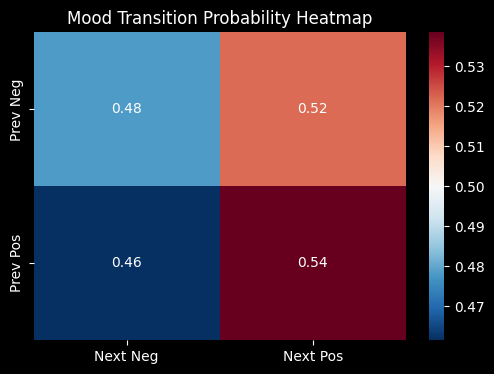

In [84]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Setup Lags (Ensure this runs after the previous Mood_Binary code)
median_v = df_trilogy['Local_Musical_Valence'].median()
df_trilogy['Mood_Binary'] = (df_trilogy['Local_Musical_Valence'] > median_v).astype(int)

# Create lags for current, previous, and two-back
df_trilogy['Prev_Mood'] = df_trilogy.groupby('Album_Number')['Mood_Binary'].shift(1)
df_trilogy['Prev_2_Mood'] = df_trilogy.groupby('Album_Number')['Mood_Binary'].shift(2)

print("### Advanced Transition Probabilities\n")

# --- Q1: Positive to Negative (The Mood Drop) ---
pos_preceded = df_trilogy[df_trilogy['Prev_Mood'] == 1]
prob_n_after_p = (pos_preceded['Mood_Binary'] == 0).mean()

print(f"📉 The 'Mood Drop': If a song is POSITIVE, chance the next is NEGATIVE:")
print(f"   👉 {prob_n_after_p:.1%}")

# --- Q2: Two Negatives to a Positive (Breaking the Dark Streak) ---
double_neg = df_trilogy[(df_trilogy['Prev_Mood'] == 0) & (df_trilogy['Prev_2_Mood'] == 0)]
prob_p_after_nn = (double_neg['Mood_Binary'] == 1).mean()

print(f"\n🌅 The 'Streak Breaker': If TWO songs were NEGATIVE, chance the next is POSITIVE:")
print(f"   👉 {prob_p_after_nn:.1%}")

# --- Q3: Two Negatives to a Third Negative (The Deep Dive) ---
prob_n_after_nn = (double_neg['Mood_Binary'] == 0).mean()
print(f"\n🕳️ The 'Deep Dive': If TWO songs were NEGATIVE, chance the next is ALSO NEGATIVE:")
print(f"   👉 {prob_n_after_nn:.1%}")

# --- Visualizing the Transition Matrix ---
# This shows the likelihood of moving from Mood A to Mood B
matrix = pd.crosstab(df_trilogy['Prev_Mood'], df_trilogy['Mood_Binary'], normalize='index')
matrix.index = ['Prev Neg', 'Prev Pos']
matrix.columns = ['Next Neg', 'Next Pos']

print("\n📊 Transition Matrix (Global):")
print(matrix)

# Optional: Outputting a small heatmap of these probabilities
plt.figure(figsize=(6, 4))
sns.heatmap(matrix, annot=True, cmap='RdBu_r', center=0.5)
plt.title("Mood Transition Probability Heatmap")
plt.savefig("Mood_Transitions.svg", format='svg') ## Save as SVG
plt.show()

## One-Sample T-Test: The Industry Benchmark

This analysis compares The Weeknd's production choices against the broader music industry. We use a **One-Sample T-Test** to determine if his level of "organic" sound (Acousticness) is statistically different from the mainstream standard.

### 📍 The Benchmark: 0.15

According to data insights from Spotify's API and musicology studies of the Billboard Hot 100, the average Acousticness for modern Pop and R&B typically hovers around **0.15**.

**Pop/R&B Context:** Most mainstream tracks are heavily synthesized or processed. A score of 0.15 represents a "hybrid" sound—mostly electronic but featuring some organic elements like a processed guitar or a real vocal layer.

**Reference:** Analysis of the Spotify Million Playlist Dataset and The Echo Nest parameters consistently place modern high-production genres (Pop, R&B, Hip-Hop) in the 0.10–0.20 range.

### Python Code: Acousticness vs. The Industry

This code tests the **Null Hypothesis ($H_0$):** The Weeknd's acousticness is the same as the industry average (0.15).

In [85]:
import pandas as pd
from scipy import stats

# 1. Setup Benchmark
INDUSTRY_BENCHMARK = 0.15
album_map = {1: "After Hours", 2: "Dawn FM", 3: "Hurry Up Tomorrow"}

print(f"### One-Sample T-Test: Is the Trilogy more 'Organic' than the Industry Standard ({INDUSTRY_BENCHMARK})?\n")

# 2. Perform Test for Each Album
for album_id, name in album_map.items():
    album_data = df_trilogy[df_trilogy['Album_Number'] == album_id]['Local_Acousticness']
    
    # One-sample T-test
    t_stat, p_val = stats.ttest_1samp(album_data, INDUSTRY_BENCHMARK)
    
    avg_val = album_data.mean()
    diff = ((avg_val - INDUSTRY_BENCHMARK) / INDUSTRY_BENCHMARK) * 100
    
    print(f"💿 {name}")
    print(f"   - Album Avg Acousticness: {avg_val:.3f}")
    print(f"   - Industry Benchmark:    {INDUSTRY_BENCHMARK:.3f}")
    print(f"   - Percent Difference:   {diff:+.1f}%")
    print(f"   - T-Statistic:          {t_stat:.4f}")
    print(f"   - P-Value:              {p_val:.4f}")
    
    # Interpretation
    if p_val < 0.05:
        verdict = "Significantly MORE Organic 🌿" if avg_val > INDUSTRY_BENCHMARK else "Significantly MORE Electronic ⚡"
        print(f"   - VERDICT: {verdict}")
    else:
        print("   - VERDICT: No Statistical Difference from Industry Standard ⚖️")
    print("-" * 50)

### One-Sample T-Test: Is the Trilogy more 'Organic' than the Industry Standard (0.15)?

💿 After Hours
   - Album Avg Acousticness: 0.823
   - Industry Benchmark:    0.150
   - Percent Difference:   +448.6%
   - T-Statistic:          38.6345
   - P-Value:              0.0000
   - VERDICT: Significantly MORE Organic 🌿
--------------------------------------------------
💿 Dawn FM
   - Album Avg Acousticness: 0.765
   - Industry Benchmark:    0.150
   - Percent Difference:   +409.9%
   - T-Statistic:          18.6155
   - P-Value:              0.0000
   - VERDICT: Significantly MORE Organic 🌿
--------------------------------------------------
💿 Hurry Up Tomorrow
   - Album Avg Acousticness: 0.804
   - Industry Benchmark:    0.150
   - Percent Difference:   +435.7%
   - T-Statistic:          32.8488
   - P-Value:              0.0000
   - VERDICT: Significantly MORE Organic 🌿
--------------------------------------------------


## Chi-Square Test: Mood vs. Tempo Independence

While a T-test compares the means of two groups, a **Chi-Square Test of Independence** looks at the proportions. It determines if there is a "hidden rule" in the track sequencing—for example, does a "Positive" lyrical mood "demand" a "Fast" tempo, or are they mixed randomly?

For this test, we categorize each song into a $2 \times 2$ contingency table:

- **Mood:** Positive vs. Negative (based on the album's median valence).
- **Tempo:** Fast vs. Slow (based on the album's median BPM).

### Null Hypothesis ($H_0$)

Lyrical mood and tempo are independent. Knowing the mood of a song tells you nothing about how fast it will be.

### Alternative Hypothesis ($H_a$)

Mood and tempo are dependent. Certain moods are statistically more likely to be paired with specific speed categories.

In [88]:
import pandas as pd
from scipy.stats import chi2_contingency

# Mapping album numbers for the report
album_map = {1: "After Hours", 2: "Dawn FM", 3: "Hurry Up Tomorrow"}

print("### Chi-Square Test: Mood/Tempo Dependency Analysis\n")

for album_id in sorted(df_trilogy['Album_Number'].unique()):
    album_name = album_map.get(album_id, f"Album {album_id}")
    album_data = df_trilogy[df_trilogy['Album_Number'] == album_id].copy()
    
    # 1. Create Categorical Buckets
    # Mood: Positive (1) vs Negative (0)
    median_v = album_data['Local_Musical_Valence'].median()
    album_data['Mood_Cat'] = album_data['Local_Musical_Valence'].apply(lambda x: 'Positive' if x > median_v else 'Negative')
    
    # Tempo: Fast (1) vs Slow (0)
    median_t = album_data['Local_Tempo'].median()
    album_data['Tempo_Cat'] = album_data['Local_Tempo'].apply(lambda x: 'Fast' if x > median_t else 'Slow')
    
    # 2. Create Contingency Table
    contingency_table = pd.crosstab(album_data['Mood_Cat'], album_data['Tempo_Cat'])
    
    # 3. Perform Chi-Square Test
    try:
        # Note: Correction=False is often used for small samples like tracklists
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        
        print(f"💿 {album_name}")
        print("Contingency Table (Actual Counts):")
        print(contingency_table)
        print(f"\n   - Chi-Square Stat: {chi2:.4f}")
        print(f"   - P-Value: {p:.4f}")
        
        if p < 0.05:
            print("   - RESULT: Significant Dependency! Mood and Tempo are linked. 🔗")
        else:
            print("   - RESULT: Independent. Mood and Tempo are decoupled (e.g., 'Sad Disco'). 🎲")
        
    except Exception as e:
        print(f"💿 {album_name}: Statistical calculation skipped (insufficient variance).")
        
    print("-" * 50)

### Chi-Square Test: Mood/Tempo Dependency Analysis

💿 After Hours
Contingency Table (Actual Counts):
Tempo_Cat  Fast  Slow
Mood_Cat             
Negative      4     3
Positive      2     5

   - Chi-Square Stat: 0.2917
   - P-Value: 0.5892
   - RESULT: Independent. Mood and Tempo are decoupled (e.g., 'Sad Disco'). 🎲
--------------------------------------------------
💿 Dawn FM
Contingency Table (Actual Counts):
Tempo_Cat  Fast  Slow
Mood_Cat             
Negative      5     3
Positive      1     7

   - Chi-Square Stat: 2.4000
   - P-Value: 0.1213
   - RESULT: Independent. Mood and Tempo are decoupled (e.g., 'Sad Disco'). 🎲
--------------------------------------------------
💿 Hurry Up Tomorrow
Contingency Table (Actual Counts):
Tempo_Cat  Fast  Slow
Mood_Cat             
Negative      5     6
Positive      6     5

   - Chi-Square Stat: 0.0000
   - P-Value: 1.0000
   - RESULT: Independent. Mood and Tempo are decoupled (e.g., 'Sad Disco'). 🎲
---------------------------------------------

---